## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [20]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import torch
import random
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=c24918cf-fa2a-4a7d-987e-8f5b3ecefa74
To: /Users/Matthieu/Documents/GitHub/NX-414-Team-16/IT_data.h5
100%|██████████| 384M/384M [01:03<00:00, 6.08MB/s] 


'IT_data.h5'

In [ ]:
def set_seed(seed=0):
    print('Deterministic code, set seed to', seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 6
set_seed(seed=seed)

Deterministic code, set seed to 6


In [22]:
import sys
!{sys.executable} -m pip install gdown h5py

### Load the data

In [23]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [24]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


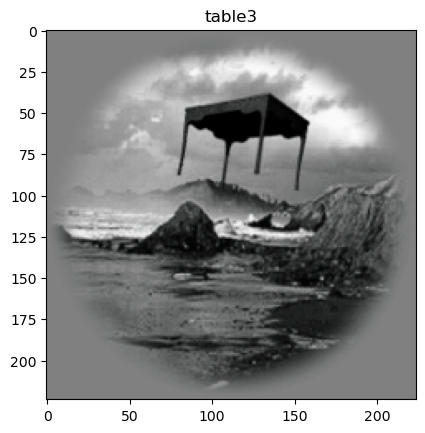

In [25]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

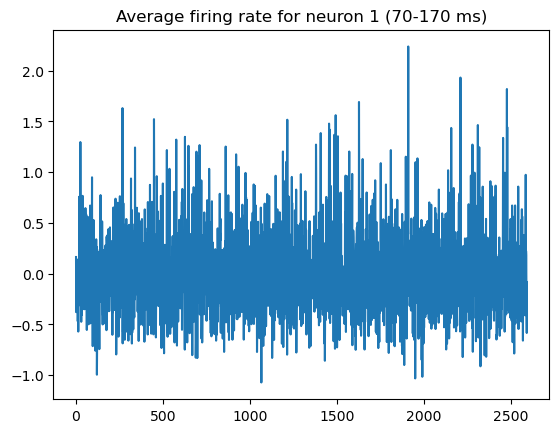

In [26]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [27]:
from utils import list_to_classes, classes_to_int

def preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val):
    """Function to preprocess data by flattening, normalizing, and augmenting with class labels.

    Args:
        stimulus_train: Training stimulus data (images).
        stimulus_val: Validation stimulus data (images).
        objects_train: Training object labels.
        objects_val: Validation object labels.

    Returns:
        X_train_augmented: Preprocessed and augmented training data.
        X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

In [28]:
from sklearn.metrics import explained_variance_score
from utils import compute_corr

def train_and_evaluate(model, model_name, X_train, X_val, spikes_train, spikes_val):
    """Function to train and evaluate a regression model.

    Args:
        model: regression model
        model_name: name of the model
        X_train: training data (features)
        X_val: validation data (features)
        spikes_train: training data (target neural activity)
        spikes_val: validation data (target neural activity)
    """
    print(f"Training {model_name}:")
    model.fit(X_train, spikes_train)

    # Make predictions using validation set
    y_pred = model.predict(X_val)

    # Compute explained variance
    ev_per_neuron = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    overall_ev = np.mean(ev_per_neuron)
    print(f'Overall explained variance: {overall_ev:.4f}')

    # Compute correlation between predicted values and real values
    corr_per_neuron = compute_corr(spikes_val, y_pred, divide=True)
    overall_corr = compute_corr(spikes_val, y_pred)
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance and correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram of explained variance per neuron
    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title(f'{model_name} - Explained variance per neuron')
    axs[0].set_xlabel('Explained variance')
    axs[0].set_ylabel('Frequency')

    # Histogram of correlation per neuron
    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title(f'{model_name} - Correlation per neuron')
    axs[1].set_xlabel('Correlation coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Training Ridge Regression:
Overall explained variance: 0.0953
Overall correlation: 0.2932


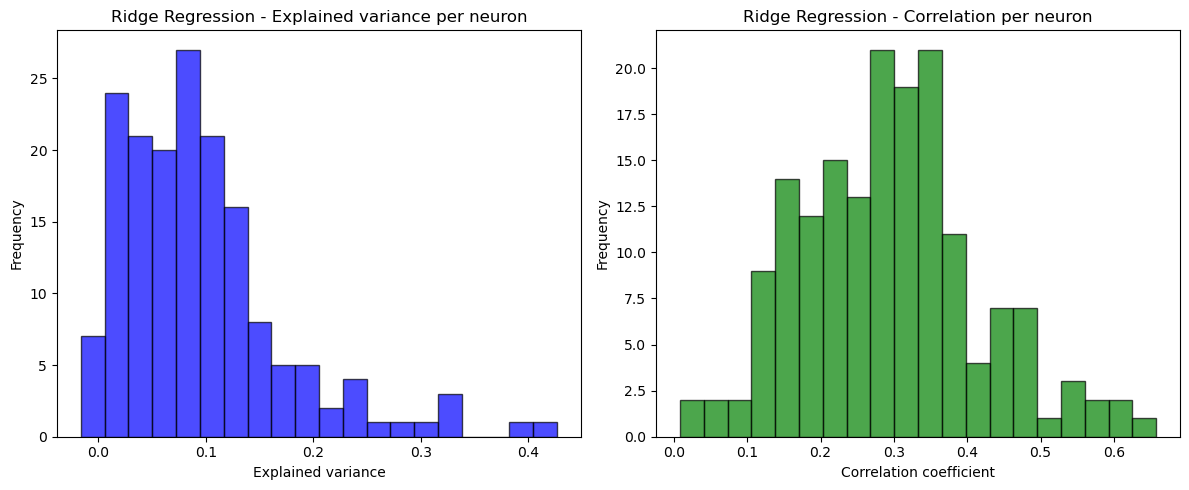

In [29]:
from sklearn.linear_model import Ridge, LinearRegression

# Preprocess data
X_train_augmented, X_val_augmented = preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val)

# Train and evaluate Ridge Regression
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-Square Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

In [30]:
from sklearn.decomposition import PCA

# Function to preprocess data with PCA
def preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000):
    """Function to preprocess data by applying PCA, normalizing, and augmenting with class labels.

    Args:
        stimulus_train: Training stimulus data (images).
        stimulus_val: Validation stimulus data (images).
        objects_train: Training object labels.
        objects_val: Validation object labels.
        n_components: Number of principal components to retain.

    Returns:
        X_train_augmented: Preprocessed and augmented training data.
        X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    print(f"PCA complete. Explained variance ratio (first {n_components} PCs): {np.sum(pca.explained_variance_ratio_):.2f}\n")

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train_pca, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val_pca, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

Training Ridge regression with PCA:
Overall explained variance: 0.0948
Overall correlation: 0.2922


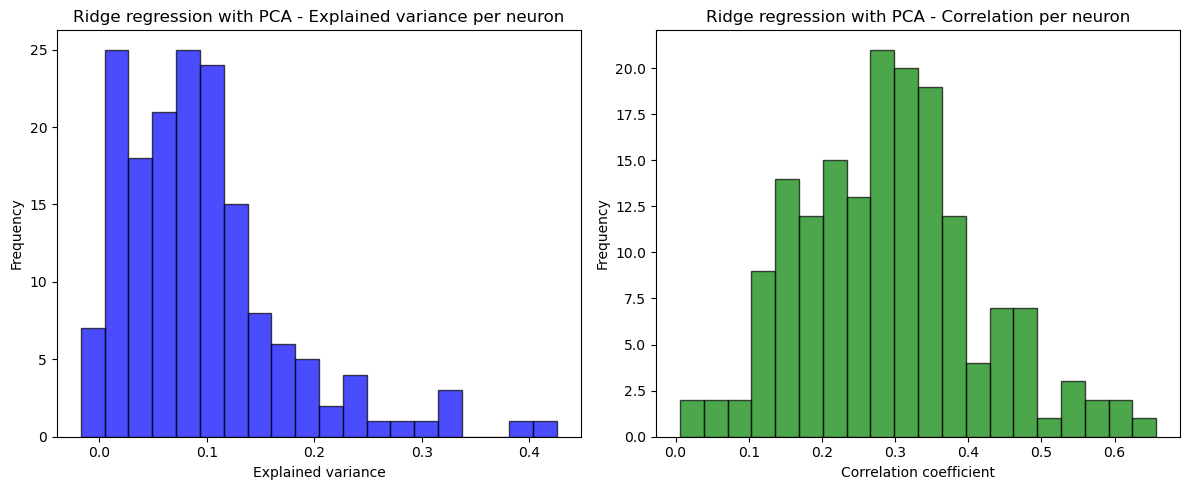

In [31]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000)

# Train and evaluate Ridge Regression with PCA
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression with PCA
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-square regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

---
### _Discussion_
The results indicate that the first 1000 principal components (PCs) capture nearly all the variance explained by the model. Specifically, the overall explained variance is **0.0948**, compared to the original value of **0.0953**, and the overall correlation is **0.2922**, compared to the original value of **0.2932**.

This minimal difference suggests that the additional PCs beyond the first 1000 contribute very little to the model's performance. Therefore, **reducing the dimensionality to the first 1000 PCs may be a reasonable trade-off between model complexity and performance**.

---

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [32]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_ridge(X, y, objects, alphas, n_splits=5):
    """Perform cross-validation to find the best alpha for Ridge Regression.

    Args:
        X: Feature matrix.
        y: Target matrix (neural activity).
        objects: Class labels for stratification.
        alphas: List of alpha values to test.
        n_splits: Number of cross-validation splits.

    Returns:
        best_alpha: The alpha value that gives the best performance.
    """
    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        fold_scores = []
        for train_idx, val_idx in skf.split(X, objects):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Train Ridge Regression
            ridge.fit(X_train, y_train)

            # Predict and evaluate explained variance
            y_pred = ridge.predict(X_val)
            ev_per_neuron = explained_variance_score(y_val, y_pred, multioutput='raw_values')
            fold_scores.append(np.mean(ev_per_neuron))

        # Average score across folds
        mean_score = np.mean(fold_scores)
        print(f"alpha={alpha}, mean explained variance: {mean_score:.4f}")

        # Update best alpha if this one is better
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha

    print(f"\nBest alpha: {best_alpha} with mean explained variance: {best_score:.4f} \n")
    return best_alpha

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

alpha=1, mean explained variance: 0.0644
alpha=2, mean explained variance: 0.0806
alpha=5, mean explained variance: 0.0873
alpha=10, mean explained variance: 0.0861
alpha=15, mean explained variance: 0.0836
alpha=30, mean explained variance: 0.0768
alpha=100, mean explained variance: 0.0595
alpha=1000, mean explained variance: 0.0274

Best alpha: 5 with mean explained variance: 0.0873 

Training Ridge regression with PCA (alpha=5):
Overall explained variance: 0.0968
Overall correlation: 0.2931


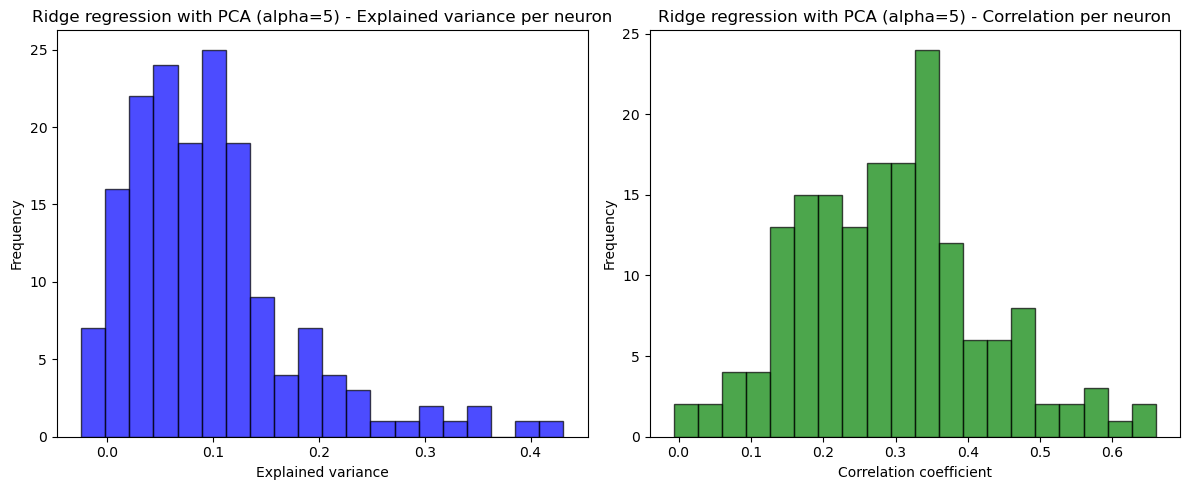

In [33]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(
    stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000
)

# Combine train and validation data for cross-validation
X_combined = np.vstack((X_train_augmented_pca, X_val_augmented_pca))
y_combined = np.vstack((spikes_train, spikes_val))
objects_combined = np.hstack((objects_train, objects_val))

# Perform cross-validation to find the best alpha
alphas = [1, 2, 5, 10, 15, 30, 100, 1000]
best_alpha = cross_validate_ridge(X_combined, y_combined, objects_combined, alphas)

# Train and evaluate Ridge Regression with the best alpha
ridge = Ridge(alpha=best_alpha, fit_intercept=True)
train_and_evaluate(ridge, f"Ridge regression with PCA (alpha={best_alpha})", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

---
### _Discussion_
We observe a slight improvement in prediction performance by using cross-fold validation to optimize the alpha parameter for ridge regression. With the best alpha value of **5**, the overall explained variance increases from **0.0948** to **0.0968**, and the overall correlation improves from **0.2922** to **0.2931** (compared to the original alpha value of **10**).

However, despite these efforts, the improvement in explained variance and correlation is minimal. This suggests that **the model struggles to generalize effectively to new data.** The principal reason is the **model complexity:** the ridge regression model may not be expressive enough to capture the underlying patterns in the data.

---

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [24]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### _Custom Stimuli Dataset Class Definition_

In [ ]:
class StimuliDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading visual stimuli and optional neural response data.

    Parameters
    ----------
    stimuli : np.ndarray or list
        A collection of image stimuli, expected as a NumPy array or list of arrays.
    responses : np.ndarray or list, optional
        Corresponding neural response vectors for each stimulus. If None, dataset returns only stimuli.
    transform : callable, optional
        A function/transform to apply to each stimulus (e.g., normalization).

    Methods
    -------
    __len__():
        Returns the number of samples in the dataset.

    __getitem__(idx):
        Returns the transformed stimulus and corresponding response (if available) at the given index.
    """

    def __init__(self, stimuli, responses=None, transform=None):
        self.stimuli = stimuli
        self.responses = responses
        self.transform = transform

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        x = self.stimuli[idx]
        if self.transform:
            x = self.transform(torch.tensor(x).float())
        return (x, self.responses[idx]) if self.responses is not None else x

### _Data Preparation: Datasets, Transforms, and DataLoaders_

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = StimuliDataset(stimulus_train, spikes_train, transform=transform)
val_dataset = StimuliDataset(stimulus_val, spikes_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

### _Activation Extraction Utility Function_

In [ ]:
def extract_activations(model, loader, layer_name):
    """
    Extracts and flattens activations from a specified layer of a model for all inputs in a DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model from which to extract activations.
    loader : torch.utils.data.DataLoader
        DataLoader providing input data in batches.
    layer_name : str
        Name of the layer (as registered in model.named_modules()) to hook and extract activations from.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (N, D) where N is the number of samples and D is the flattened activation dimension
        from the specified layer.
    """
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy().reshape(output.size(0), -1))

    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            _ = model(imgs)

    hook.remove()

    return np.concatenate(activations, axis=0)


### _Layer-wise Evaluation: PCA + Linear Regression on Pretrained ResNet50_

In [ ]:
model = models.resnet50(pretrained=True).to(device).eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
results = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act = extract_activations(model, train_loader, layer)
    val_act = extract_activations(model, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pcs = pca.fit_transform(train_act)
    X_val_pcs = pca.transform(val_act)

    # Linear Regression
    lr = LinearRegression().fit(X_train_pcs, spikes_train)
    preds_val = lr.predict(X_val_pcs)

    # Evaluation metrics
    ev = explained_variance_score(spikes_val, preds_val)
    correlations = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr = np.mean(correlations)

    results[layer] = {'explained_variance': ev, 'mean_correlation': avg_corr}

    print(f"{layer} | EV: {ev:.4f}, Mean Corr: {avg_corr:.4f}")
    

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing conv1
conv1 | EV: -0.0290, Mean Corr: 0.2378
Processing layer1
layer1 | EV: 0.2081, Mean Corr: 0.4678
Processing layer2
layer2 | EV: 0.2208, Mean Corr: 0.4848
Processing layer3
layer3 | EV: 0.2598, Mean Corr: 0.5213
Processing layer4
layer4 | EV: 0.1903, Mean Corr: 0.4752
Processing avgpool
avgpool | EV: -0.0780, Mean Corr: 0.3395


### _Comments on results_
This show how well different layers of a pretrained ResNet50 explain neural activity in the brain, using **explained variance (EV)** and **mean Pearson correlation (Corr)** between predicted and actual neural responses.

---

#### **Summary of Layer-wise Results**

| Layer     | Explained Variance (EV) | Mean Correlation (Corr) | Interpretation |
|-----------|--------------------------|--------------------------|----------------|
| `conv1`   | -0.0290                  | 0.2378                   | Very low predictive power. Negative EV means it's worse than predicting the mean. |
| `layer1`  | 0.2081                   | 0.4678                   | Substantial increase. Early convolutional features begin to capture meaningful structure. |
| `layer2`  | 0.2208                   | 0.4848                   | Slight improvement. Feature complexity increases; more aligned with neural coding. |
| `layer3`  | **0.2598**               | **0.5213**               | **Peak performance**. Captures mid-level representations similar to IT cortex. |
| `layer4`  | 0.1903                   | 0.4752                   | Drop in EV and Corr. Possibly due to over-compression or task-specific abstraction. |
| `avgpool` | -0.0780                  | 0.3395                   | Sharp drop. Final layer is highly task-optimized (e.g., for classification), discarding variance needed for regression. |

---

#### **Interpretation**

- **Best-performing layer:** `layer3`, both in EV and correlation. This supports the idea that **mid-to-deep layers** in CNNs most closely match the representational geometry of high-level visual areas like IT.
  
- **Decline in deeper layers:** The drop in performance at `layer4` and especially `avgpool` suggests that later layers become increasingly abstract and invariant — optimized for classification rather than preserving detailed variance in neural firing patterns.

- **Early layers insufficient:** `conv1` performs poorly. This is expected — low-level features like edges or textures don’t carry the complexity needed to explain IT neuron responses.

---

#### **Conclusion**

These results align well with the idea that **task-trained CNNs best approximate brain activity at intermediate depths**, where abstract yet not fully class-specific features are most prominent. The **non-monotonic trend** (rising then falling) is characteristic of both artificial and biological hierarchies.

### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized ResNet50_

In [ ]:
model_rand = models.resnet50(pretrained=False).to(device).eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
results_rand  = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand = extract_activations(model_rand, train_loader, layer)
    val_act_rand  = extract_activations(model_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand  = pca_rand .fit_transform(train_act_rand)
    X_val_pcs_rand  = pca_rand .transform(val_act_rand)

    # Linear Regression
    lr_rand  = LinearRegression().fit(X_train_pcs_rand , spikes_train )
    preds_val_rand  = lr_rand .predict(X_val_pcs_rand )

    # Evaluation metrics
    ev_rand  = explained_variance_score(spikes_val, preds_val_rand )
    correlations_rand  = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand  = np.mean(correlations_rand )

    results_rand[layer] = {'explained_variance': ev_rand, 'mean_correlation': avg_corr_rand}

    print(f"{layer} | EV: {ev_rand:.4f}, Mean Corr: {avg_corr_rand:.4f}")
    

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing conv1
conv1 | EV: -0.0833, Mean Corr: 0.2172
Processing layer1
layer1 | EV: 0.1301, Mean Corr: 0.4025
Processing layer2
layer2 | EV: 0.1689, Mean Corr: 0.4302
Processing layer3
layer3 | EV: 0.1547, Mean Corr: 0.4200
Processing layer4
layer4 | EV: 0.1226, Mean Corr: 0.3976
Processing avgpool
avgpool | EV: -0.0686, Mean Corr: 0.3262


### _Layer-wise Performance Comparison: Pretrained vs Random (EV & Correlation)_

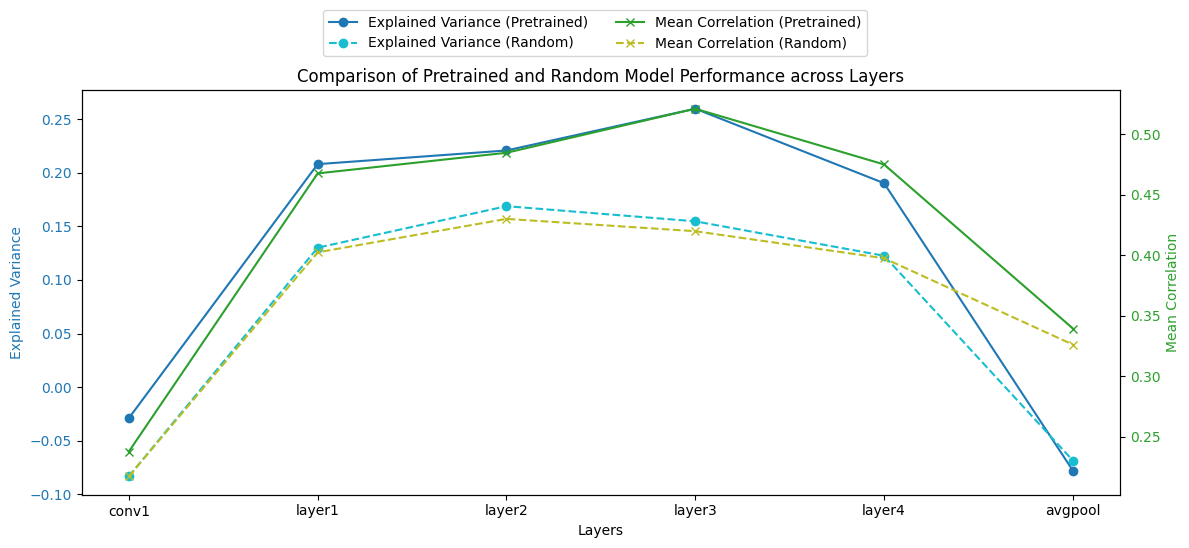

In [ ]:
layers_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

explained_vars_pre = [results[layer]['explained_variance'] for layer in layers_labels]
correlations_pre = [results[layer]['mean_correlation'] for layer in layers_labels]
explained_vars_rand = [results_rand[layer]['explained_variance'] for layer in layers_labels]
correlations_rand = [results_rand[layer]['mean_correlation'] for layer in layers_labels]

fig, ax1 = plt.subplots(figsize=(12, 5))

# Explained Variance (left axis)
color_ev_pre = 'tab:blue'
color_ev_rand = 'tab:cyan'
ax1.set_xlabel('Layers')
ax1.set_ylabel('Explained Variance', color=color_ev_pre)
ax1.plot(layers_labels, explained_vars_pre, color=color_ev_pre, marker='o', label='Explained Variance (Pretrained)')
ax1.plot(layers_labels, explained_vars_rand, color=color_ev_rand, marker='o', linestyle='--', label='Explained Variance (Random)')
ax1.tick_params(axis='y', labelcolor=color_ev_pre)

# Mean Correlation (right axis)
ax2 = ax1.twinx()
color_corr_pre = 'tab:green'
color_corr_rand = 'tab:olive'
ax2.set_ylabel('Mean Correlation', color=color_corr_pre)
ax2.plot(layers_labels, correlations_pre, color=color_corr_pre, marker='x', label='Mean Correlation (Pretrained)')
ax2.plot(layers_labels, correlations_rand, color=color_corr_rand, marker='x', linestyle='--', label='Mean Correlation (Random)')
ax2.tick_params(axis='y', labelcolor=color_corr_pre)

# Legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title('Comparison of Pretrained and Random Model Performance across Layers')
fig.tight_layout()
plt.show()

- **Pretrained > Random** at all layers — task training improves neural prediction.  
- **Best layer: `layer3`** — aligns most with IT cortex.  
- **`avgpool` drops** — overcompressed, class-specific.  
- **Random model weak overall**, slight peak at mid-layers.

### _Neuron-Level Performance Distribution: Pretrained vs Random_

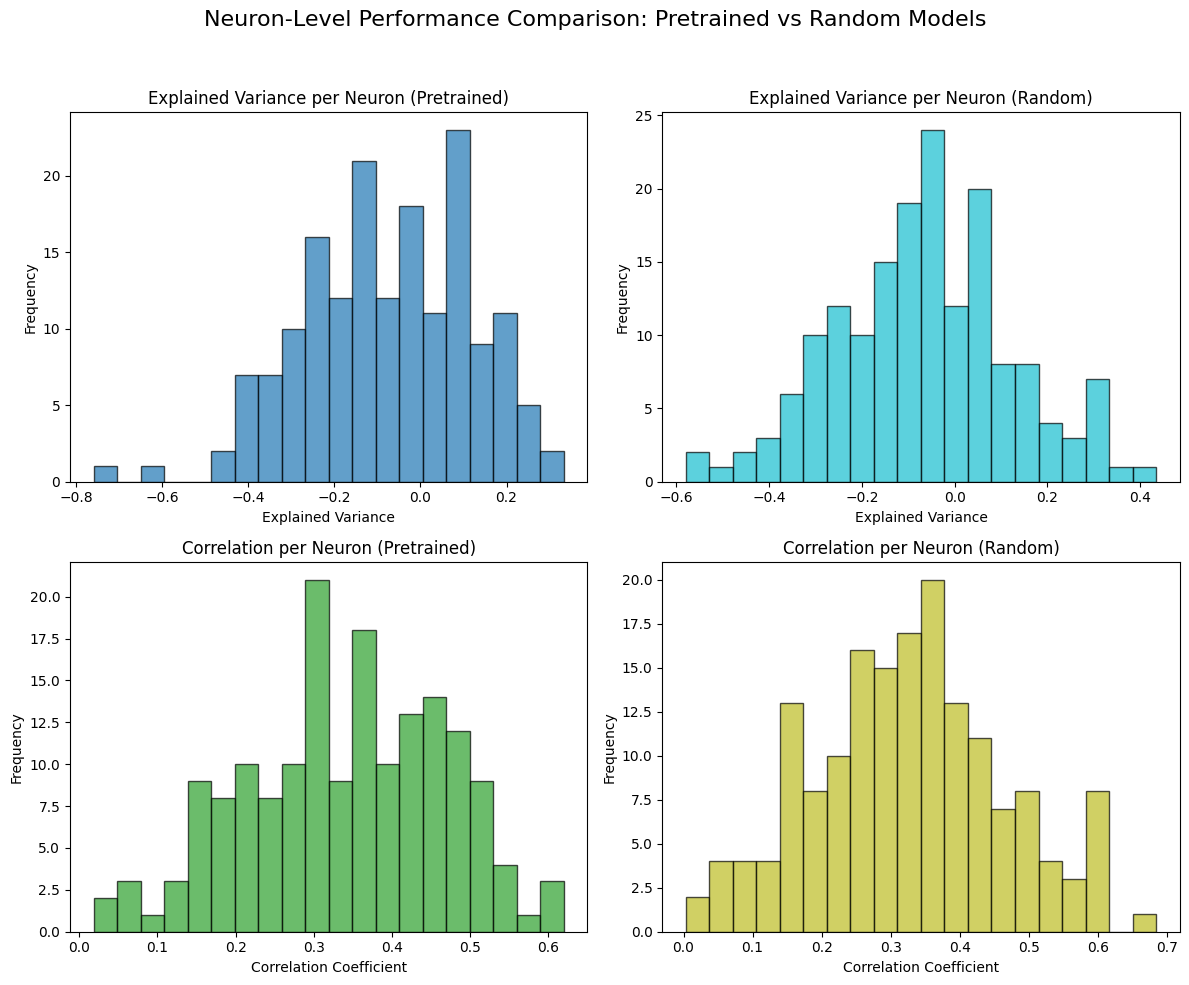

In [42]:
# Calculate per-neuron metrics
explained_variance_per_neuron_pre = 1 - np.var(spikes_val - preds_val, axis=0) / np.var(spikes_val, axis=0)
correlation_per_neuron_pre = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]

explained_variance_per_neuron_rand = 1 - np.var(spikes_val - preds_val_rand, axis=0) / np.var(spikes_val, axis=0)
correlation_per_neuron_rand = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]

# Plot histograms for comparison
fig, axs = plt.subplots(2, 2, figsize=(1 2, 10))

# Explained Variance per neuron
axs[0, 0].hist(explained_variance_per_neuron_pre, bins=20, color='tab:blue', alpha=0.7, edgecolor='black')
axs[0, 0].set_title('Explained Variance per Neuron (Pretrained)')
axs[0, 0].set_xlabel('Explained Variance')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(explained_variance_per_neuron_rand, bins=20, color='tab:cyan', alpha=0.7, edgecolor='black')
axs[0, 1].set_title('Explained Variance per Neuron (Random)')
axs[0, 1].set_xlabel('Explained Variance')
axs[0, 1].set_ylabel('Frequency')

# Correlation per neuron
axs[1, 0].hist(correlation_per_neuron_pre, bins=20, color='tab:green', alpha=0.7, edgecolor='black')
axs[1, 0].set_title('Correlation per Neuron (Pretrained)')
axs[1, 0].set_xlabel('Correlation Coefficient')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(correlation_per_neuron_rand, bins=20, color='tab:olive', alpha=0.7, edgecolor='black')
axs[1, 1].set_title('Correlation per Neuron (Random)')
axs[1, 1].set_xlabel('Correlation Coefficient')
axs[1, 1].set_ylabel('Frequency')

plt.suptitle('Neuron-Level Performance Comparison: Pretrained vs Random Models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These histograms show **per-neuron explained variance** and **correlation** distributions for pretrained and random models.

---

###  **Explained Variance (Top Row)**
- **Pretrained (left)**: Distribution is **centered slightly above 0**, with some neurons reaching ~0.3. However, many still fall below 0.
- **Random (right)**: Most values are near or **below 0**, showing worse predictive power. Some neurons get positive EV, likely due to noise or chance.

**Conclusion**: The pretrained model offers better neuron-level predictions overall, though the explained variance remains modest. Interestingly, even in the non-pretrained ResNet, certain layers—particularly layers 2 and 3—exhibit relatively high explained variance. This suggests that the architecture of ResNet alone, independent of pretraining, may inherently capture features that align with neural activity to some extent.

---

### **Correlation (Bottom Row)**
- **Pretrained (left)**: Correlations mostly range from **0.2 to 0.5**, peaking around **0.3–0.4**.
- **Random (right)**: Lower overall, with many neurons below **0.3**, peak around **0.25–0.35**.

**Conclusion**: Pretrained model consistently produces higher correlations with neural responses. As for the explain variance, some layers of the non-pretrained ResNet show higher correlation, suggesting that its architecture may inherently capture features that align with neural activit.

---

### Summary
- Pretrained model shows **clear advantages** at the neuron level, though still far from perfect.
- Random model barely captures structure (but some layers still capture some kind of structure) — consistent with lack of task-specific features.
- Neural prediction is **distributed**, with some neurons being much better predicted than others — possibly reflecting differing selectivity or noise levels.

---

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [ ]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
from utils import train_model, evaluate_model
import matplotlib.pyplot as plt
import numpy as np
import gdown

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

### Create the dataloader

In [8]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the model

In [9]:
import torch.nn as nn

class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(32 * 56 * 56, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

# Initialize the model
n_neurons = spikes_train.shape[1]
model = ShallowCNN(n_neurons=n_neurons)

### Define the loss function and the optimizer

In [10]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Build the training script and train the model

In [11]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device='cpu', scheduler=None):
    """
    Train the model and validate it after each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        loss_function (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.to(device)

    # Learning rate scheduler
    if scheduler is None:
        # Use StepLR scheduler with step size of 5 and gamma of 0.1
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, spikes in train_dataloader:
            images, spikes = images.to(device), spikes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, spikes)

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, spikes in val_dataloader:
                images, spikes = images.to(device), spikes.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_function(outputs, spikes)

                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, "
              f"Val Loss: {val_loss/len(val_dataloader):.4f}")

        # Stop training if loss becomes NaN or Inf
        if torch.isnan(torch.tensor(train_loss)) or torch.isinf(torch.tensor(train_loss)):
            print("Training stopped due to unstable loss (NaN or Inf).")
            break

In [ ]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.8407, Val Loss: 0.1413
Epoch 2/15, Train Loss: 0.1360, Val Loss: 0.1409
Epoch 3/15, Train Loss: 0.1346, Val Loss: 0.1366
Epoch 4/15, Train Loss: 0.1273, Val Loss: 0.1246
Epoch 5/15, Train Loss: 0.1159, Val Loss: 0.1170
Epoch 6/15, Train Loss: 0.1040, Val Loss: 0.1146
Epoch 7/15, Train Loss: 0.1013, Val Loss: 0.1137
Epoch 8/15, Train Loss: 0.0994, Val Loss: 0.1133
Epoch 9/15, Train Loss: 0.0977, Val Loss: 0.1130
Epoch 10/15, Train Loss: 0.0958, Val Loss: 0.1128
Epoch 11/15, Train Loss: 0.0942, Val Loss: 0.1128
Epoch 12/15, Train Loss: 0.0939, Val Loss: 0.1128
Epoch 13/15, Train Loss: 0.0937, Val Loss: 0.1129
Epoch 14/15, Train Loss: 0.0936, Val Loss: 0.1129
Epoch 15/15, Train Loss: 0.0934, Val Loss: 0.1130


### Evaluate the predictions of the model

In [13]:
def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

[Current Model] Overall explained variance: 0.1732
[Current Model] Overall correlation: 0.4002


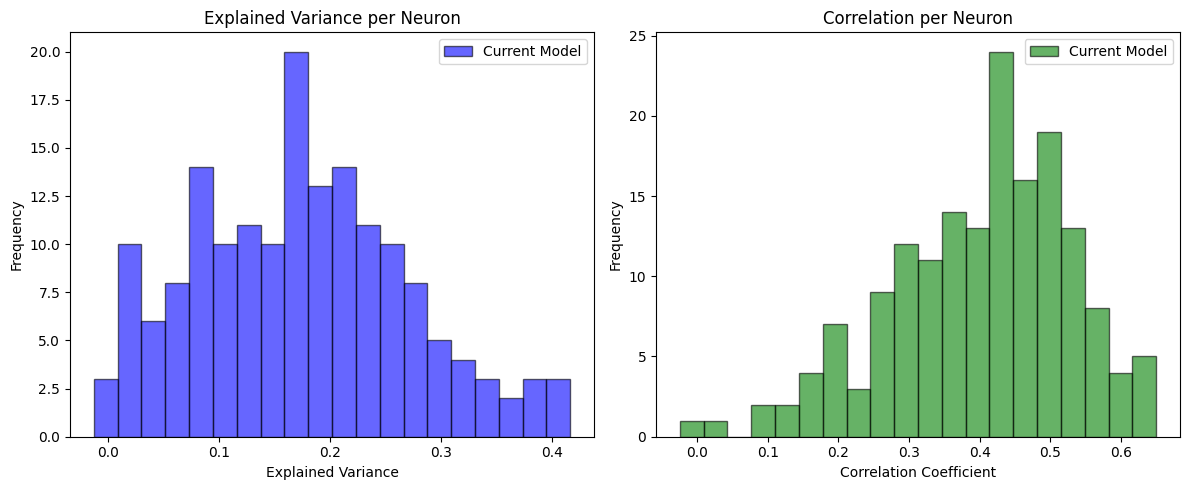

In [ ]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")

### Compare with the task-trained model

<h5>Comparison for explained variance (EV)</h5>

On the one hand, the variance of neural responses predicted by the task-trained model ranges from -0.3 to 0.2, with a lot of negative values. This suggests that the pretrained features are not perfectly aligned with the neural response, and a linear mapping might not capture the complexity of the relationship between visual stimuli and neural activity. However, some specific layers—particularly layer 3—of the task-driven model perform better than others, even outperforming the data-driven approach (CNN trained model) in certain cases. This indicates that some intermediate representations learned during task training may align more closely with neural activity.

On the other hand, the explained variance in the CNN trained model of this notebook ranges from 0 to 0.3, with a peak between 0.15 and 0.2, suggesting that the model is doing better at predicting neural responses than the first method. The positive values indicate that the model is capturing some of the relationship between the visual stimuli and the neural response, although the model's performance is still far from perfect.

To conclude, the second method—where the model learns directly from the images and neural responses—tends to produce representations that are, on average, better aligned with the task. This task-driven training allows the model to adapt its features specifically to the neural data. Interestingly, even when initialized with random weights, some layers in the ResNet architecture, such as the second layer, show similar performance (mean EV: 0.1689 for ResNet's layer2 vs. 0.1732 for the shallow CNN). This suggests that the inherent architectural design of ResNet may naturally align with certain aspects of neural processing. Furthermore, layer 3 of the pretrained ResNet model achieves even better results than our data-driven approach (mean EV: 0.2598), highlighting that some of the pretrained features can be particularly effective in predicting neural responses.

<h5>Comparison for correlation</h5>

On the one hand, the correlation range from 0.2 to 0.5 uniformly, with peaks at 0.3 and 0.35 for the task-trained model. The low to moderate correlation range suggests that the linear model is capturing some relationship between the visual stimuli (represented by the ImageNet features) and the neural response, but the model's performance is not exceptionally strong.

On the other hand, the correlation ranges from 0.2 to 0.6, with a higher frequency between 0.35 and 0.50 for the data-driven CNN model. The higher correlation range (0.2 to 0.6) indicates that the shallow CNN is much more capable of predicting neural responses. The higher frequency between 0.35 and 0.55 suggests that the shallow CNN is performing a lot better in this range, meaning the model is better aligned with the neural responses for many stimuli. 

Similarly as for the explained variance, the correlation results further support the advantage of certain ResNet layers over the shallow CNN model. The third layer of the pretrained ResNet achieves a correlation of 0.5213, outperforming the shallow CNN’s correlation of 0.4002. Notably, even the second layer of the randomly initialized ResNet surpasses the shallow CNN, with a correlation of 0.4302. These findings suggest that both the architecture and pretrained features of deeper models may be more aligned with neural activity than our current data-driven approach. This highlights the need for further refinement of our shallow CNN model, which we aim to address in the next notebook.

---

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

## Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

---

## Optimize your current models by adjusting hyperparameters and implementing different regularizations.

The first thing that we tried here is to change the normalization method so that it fits the statistics of our images and slightly change the scheduler so that the learning rate change by a 0.6 factor every 10 epochs and run for 20 epochs. This 0.6 factor every 10 epochs has been found by noticing that the model tend to converge slower at first than the model initilialized with the normalization of resnet50 (Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])).

First of all, for comparison purposes, let's retrain the original model

Important note: To ensure reproducibility, we set fixed random seeds during our experiments. However, we observed that results still vary across different environments. This discrepancy is likely due to the non-deterministic behavior of certain CUDA operations and hardware-level variations. Despite setting seeds, operations involving GPU parallelism may still introduce variability, especially across different drivers or GPU models. The results shown in this notebook have all been ran using the same Google Colab session. 

### _Retrain original model_

In [5]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [8]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_original = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset_original = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset_original = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_original = DataLoader(train_dataset_original, batch_size=32, shuffle=True, num_workers=0)
val_dataloader_original = DataLoader(val_dataset_original, batch_size=32, shuffle=False)
test_dataloader_original = DataLoader(test_dataset_original, batch_size=32, shuffle=False)

In [7]:
class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(32 * 56 * 56, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

# Initialize the model
n_neurons = spikes_train.shape[1]
shallow_cnn = ShallowCNN(n_neurons=n_neurons)

In [8]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn.parameters(), lr=learning_rate)

In [9]:
#Uses original scheduler
train_model(shallow_cnn, train_dataloader_original, val_dataloader_original, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.8407, Val Loss: 0.1413
Epoch 2/15, Train Loss: 0.1360, Val Loss: 0.1409
Epoch 3/15, Train Loss: 0.1346, Val Loss: 0.1366
Epoch 4/15, Train Loss: 0.1273, Val Loss: 0.1246
Epoch 5/15, Train Loss: 0.1159, Val Loss: 0.1170
Epoch 6/15, Train Loss: 0.1040, Val Loss: 0.1146
Epoch 7/15, Train Loss: 0.1013, Val Loss: 0.1137
Epoch 8/15, Train Loss: 0.0994, Val Loss: 0.1133
Epoch 9/15, Train Loss: 0.0977, Val Loss: 0.1130
Epoch 10/15, Train Loss: 0.0958, Val Loss: 0.1128
Epoch 11/15, Train Loss: 0.0942, Val Loss: 0.1128
Epoch 12/15, Train Loss: 0.0939, Val Loss: 0.1128
Epoch 13/15, Train Loss: 0.0937, Val Loss: 0.1129
Epoch 14/15, Train Loss: 0.0936, Val Loss: 0.1129
Epoch 15/15, Train Loss: 0.0934, Val Loss: 0.1130


[Current Model] Overall explained variance: 0.1732
[Current Model] Overall correlation: 0.4002


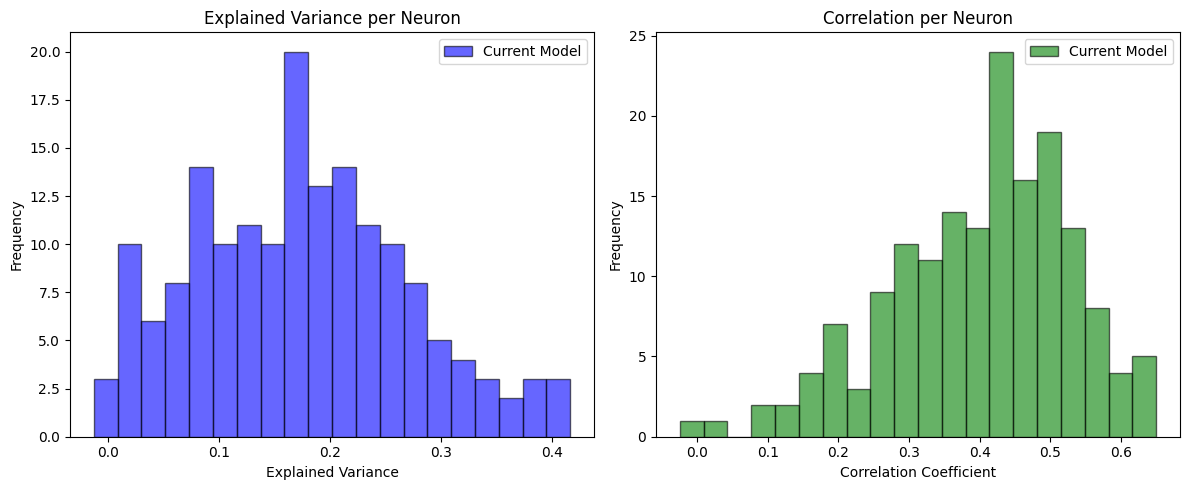

In [10]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn, val_dataloader_original, spikes_val, device="cpu")

### _Normalization + scheduler change_

In [11]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [12]:
means = stimulus_train.mean(axis=(0, 2, 3))  # mean over channels
stds = stimulus_train.std(axis=(0, 2, 3))    # std over channels

print("Dataset means:", means)
print("Dataset stds:", stds)

transform = transforms.Compose([
    transforms.Normalize(mean=means.tolist(), std=stds.tolist())
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset means: [-0.16872346 -0.04302491  0.1793886 ]
Dataset stds: [0.78718233 0.8047593  0.8011816 ]


In [13]:
shallow_cnn_norm = ShallowCNN(n_neurons=n_neurons)

In [14]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_norm.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [15]:
train_model(shallow_cnn_norm, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1561, Val Loss: 0.1399
Epoch 2/20, Train Loss: 0.1327, Val Loss: 0.1337
Epoch 3/20, Train Loss: 0.1226, Val Loss: 0.1212
Epoch 4/20, Train Loss: 0.1055, Val Loss: 0.1141
Epoch 5/20, Train Loss: 0.0938, Val Loss: 0.1113
Epoch 6/20, Train Loss: 0.0873, Val Loss: 0.1128
Epoch 7/20, Train Loss: 0.0833, Val Loss: 0.1113
Epoch 8/20, Train Loss: 0.0810, Val Loss: 0.1112
Epoch 9/20, Train Loss: 0.0790, Val Loss: 0.1095
Epoch 10/20, Train Loss: 0.0764, Val Loss: 0.1099
Epoch 11/20, Train Loss: 0.0737, Val Loss: 0.1092
Epoch 12/20, Train Loss: 0.0717, Val Loss: 0.1087
Epoch 13/20, Train Loss: 0.0704, Val Loss: 0.1091
Epoch 14/20, Train Loss: 0.0696, Val Loss: 0.1089
Epoch 15/20, Train Loss: 0.0689, Val Loss: 0.1088
Epoch 16/20, Train Loss: 0.0682, Val Loss: 0.1091
Epoch 17/20, Train Loss: 0.0677, Val Loss: 0.1093
Epoch 18/20, Train Loss: 0.0673, Val Loss: 0.1090
Epoch 19/20, Train Loss: 0.0671, Val Loss: 0.1089
Epoch 20/20, Train Loss: 0.0667, Val Loss: 0.1094


[Current Model] Overall explained variance: 0.1961
[Current Model] Overall correlation: 0.4362
[Previous Model] Overall explained variance: 0.1732
[Previous Model] Overall correlation: 0.4002


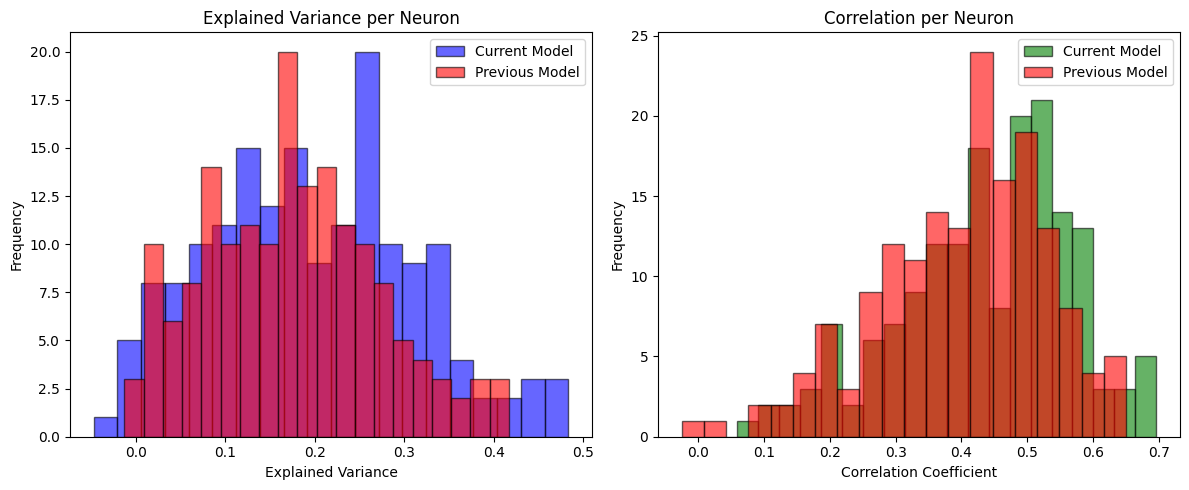

In [16]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_norm, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn, prev_dataloader=val_dataloader_original)

---

Here we notice a slight improvement compared to the original model, where the overall explained variance increased from 0.1732 to 0.1961, and the overall correlation improved from 0.4002 to 0.4362. This suggests that the changes made, such as normalization adjustment and scheduler modification, are beneficial. Let's continue optimizing the method further to achieve even better results.

---

### _Dropout regularization change_

What we tried next is to decrease the dropout rate. We decided to set to 0.2

In [17]:
class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Change
        self.fc = nn.Linear(32 * 56 * 56, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

In [18]:
shallow_cnn_drop = ShallowCNN(n_neurons=n_neurons)
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_drop.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [19]:
train_model(shallow_cnn_drop, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.2780, Val Loss: 0.1412
Epoch 2/20, Train Loss: 0.1360, Val Loss: 0.1409
Epoch 3/20, Train Loss: 0.1328, Val Loss: 0.1301
Epoch 4/20, Train Loss: 0.1164, Val Loss: 0.1161
Epoch 5/20, Train Loss: 0.0997, Val Loss: 0.1154
Epoch 6/20, Train Loss: 0.0904, Val Loss: 0.1129
Epoch 7/20, Train Loss: 0.0852, Val Loss: 0.1124
Epoch 8/20, Train Loss: 0.0818, Val Loss: 0.1128
Epoch 9/20, Train Loss: 0.0793, Val Loss: 0.1123
Epoch 10/20, Train Loss: 0.0776, Val Loss: 0.1124
Epoch 11/20, Train Loss: 0.0761, Val Loss: 0.1113
Epoch 12/20, Train Loss: 0.0744, Val Loss: 0.1118
Epoch 13/20, Train Loss: 0.0735, Val Loss: 0.1116
Epoch 14/20, Train Loss: 0.0726, Val Loss: 0.1119
Epoch 15/20, Train Loss: 0.0719, Val Loss: 0.1117
Epoch 16/20, Train Loss: 0.0713, Val Loss: 0.1115
Epoch 17/20, Train Loss: 0.0707, Val Loss: 0.1120
Epoch 18/20, Train Loss: 0.0700, Val Loss: 0.1114
Epoch 19/20, Train Loss: 0.0693, Val Loss: 0.1114
Epoch 20/20, Train Loss: 0.0685, Val Loss: 0.1110


[Current Model] Overall explained variance: 0.1801
[Current Model] Overall correlation: 0.4196
[Previous Model] Overall explained variance: 0.1961
[Previous Model] Overall correlation: 0.4362


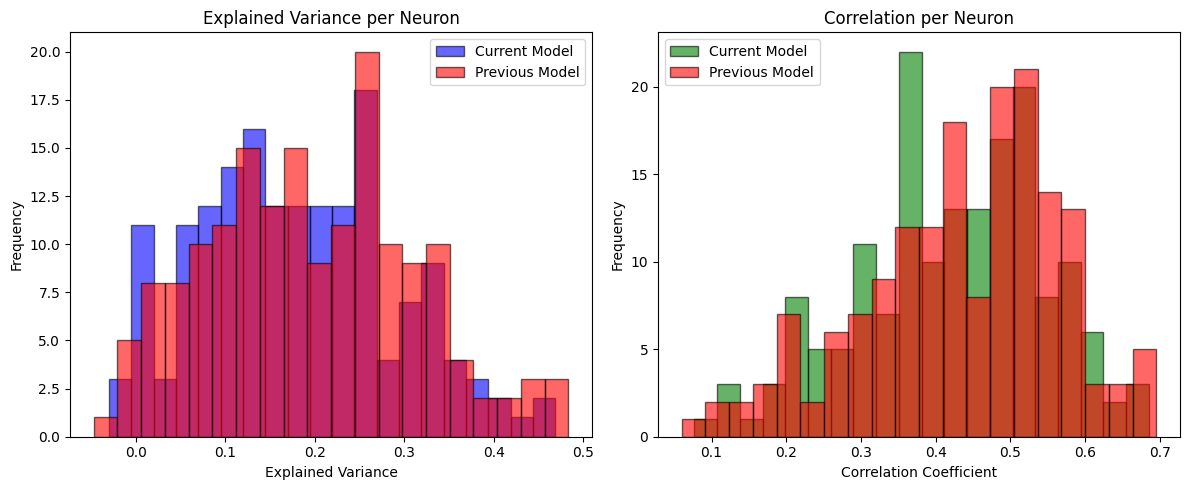

In [20]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_drop, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_norm, prev_dataloader=val_dataloader)

---

As shown here, adjusting the dropout rate to 0.2 led to a slight decline in performance—EV decreased from 0.1961 to 0.1801, and correlation decreased from 0.4362 to 0.4196. The dropout prevents the network from becoming too dependent on specific patterns. The idea comes from the fact that we thought that the dropout might decrease the representation power of the network. Moreover, the dropout being a parameter that helps smoothen convergence, it caused instability during training, requiring us to rerun the training three times before achieving convergence, as the other two attempts resulted in divergence during gradient descent. Even in the previous trainings, from time to time, the model fails to coverge to its minimal value and either diverges or stagnates to a local minimum. This motivates or choice to add L2 regularization.

---

### _Dropout regularization change + L2 regularization_

To solve those problems, we decided to add a little of L2 regularization inside of the optimizer (weight_decay=1e-5). The motivation for reducing the dropout is that the risk with the dropout might lead to not using the model to its full potential. The motivation of setting a weight_decay is that we still want some sort of regularization.

In [21]:
shallow_cnn_l2 = ShallowCNN(n_neurons=n_neurons)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_l2.parameters(), lr=learning_rate, weight_decay=1e-5)  # Change
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [22]:
train_model(shallow_cnn_l2, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1994, Val Loss: 0.1414
Epoch 2/20, Train Loss: 0.1360, Val Loss: 0.1410
Epoch 3/20, Train Loss: 0.1358, Val Loss: 0.1410
Epoch 4/20, Train Loss: 0.1348, Val Loss: 0.1381
Epoch 5/20, Train Loss: 0.1288, Val Loss: 0.1228
Epoch 6/20, Train Loss: 0.1117, Val Loss: 0.1142
Epoch 7/20, Train Loss: 0.0959, Val Loss: 0.1116
Epoch 8/20, Train Loss: 0.0870, Val Loss: 0.1110
Epoch 9/20, Train Loss: 0.0815, Val Loss: 0.1105
Epoch 10/20, Train Loss: 0.0776, Val Loss: 0.1092
Epoch 11/20, Train Loss: 0.0731, Val Loss: 0.1085
Epoch 12/20, Train Loss: 0.0697, Val Loss: 0.1079
Epoch 13/20, Train Loss: 0.0677, Val Loss: 0.1080
Epoch 14/20, Train Loss: 0.0660, Val Loss: 0.1078
Epoch 15/20, Train Loss: 0.0643, Val Loss: 0.1078
Epoch 16/20, Train Loss: 0.0624, Val Loss: 0.1081
Epoch 17/20, Train Loss: 0.0613, Val Loss: 0.1085
Epoch 18/20, Train Loss: 0.0603, Val Loss: 0.1081
Epoch 19/20, Train Loss: 0.0594, Val Loss: 0.1088
Epoch 20/20, Train Loss: 0.0581, Val Loss: 0.1078


[Current Model] Overall explained variance: 0.2081
[Current Model] Overall correlation: 0.4526
[Previous Model] Overall explained variance: 0.1801
[Previous Model] Overall correlation: 0.4196


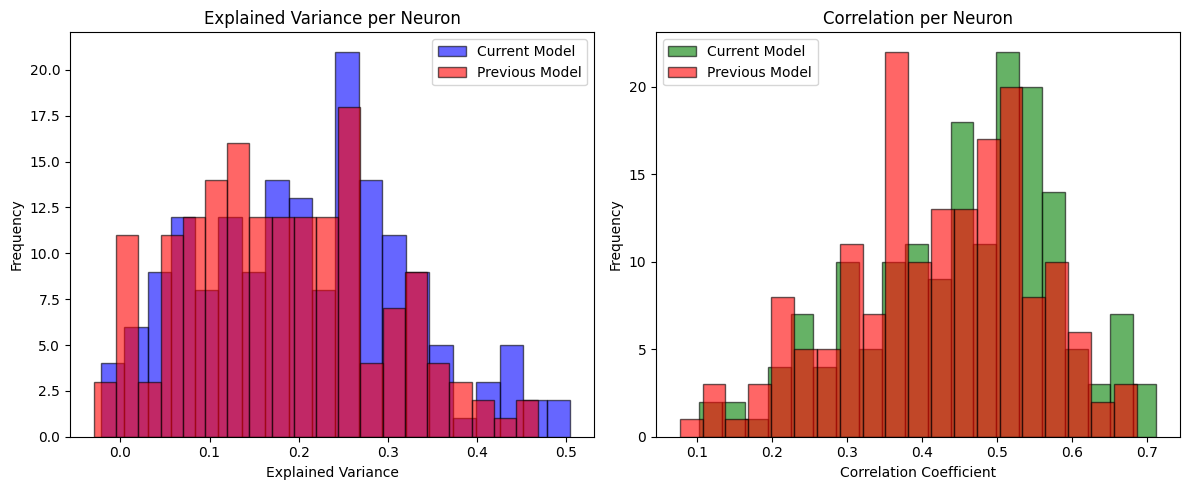

In [23]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_l2, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_drop, prev_dataloader=val_dataloader)

---

We can see a very subtle improvement, with the overall explained variance decreasing to 0.2081 and the overall correlation improving to 0.4526. The main thing about L2 regularization is that it helped us converge almost all of the time. However, we deduced from our results that the model is likely not expressive enough, and to improve performance, we would need a model with more parameters or a different architecture.

---

### _Update of architecture_

The goal of this part is to add a layer to the architecture and see if it adds anything to the performance of the model. Here we add one convilutionnal layer.

In [24]:
class DeeperCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Change
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(64 * 28 * 28, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))  # Change
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

In [25]:
# Initialize the model
n_neurons = spikes_train.shape[1]
deeper_cnn = DeeperCNN(n_neurons=n_neurons)

In [26]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(deeper_cnn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [27]:
train_model(deeper_cnn, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1401, Val Loss: 0.1362
Epoch 2/20, Train Loss: 0.1241, Val Loss: 0.1215
Epoch 3/20, Train Loss: 0.1105, Val Loss: 0.1109
Epoch 4/20, Train Loss: 0.1011, Val Loss: 0.1089
Epoch 5/20, Train Loss: 0.0936, Val Loss: 0.1046
Epoch 6/20, Train Loss: 0.0873, Val Loss: 0.1038
Epoch 7/20, Train Loss: 0.0812, Val Loss: 0.1030
Epoch 8/20, Train Loss: 0.0771, Val Loss: 0.1043
Epoch 9/20, Train Loss: 0.0739, Val Loss: 0.1044
Epoch 10/20, Train Loss: 0.0712, Val Loss: 0.1048
Epoch 11/20, Train Loss: 0.0681, Val Loss: 0.1041
Epoch 12/20, Train Loss: 0.0657, Val Loss: 0.1052
Epoch 13/20, Train Loss: 0.0644, Val Loss: 0.1055
Epoch 14/20, Train Loss: 0.0635, Val Loss: 0.1068
Epoch 15/20, Train Loss: 0.0628, Val Loss: 0.1068
Epoch 16/20, Train Loss: 0.0623, Val Loss: 0.1075
Epoch 17/20, Train Loss: 0.0618, Val Loss: 0.1069
Epoch 18/20, Train Loss: 0.0616, Val Loss: 0.1081
Epoch 19/20, Train Loss: 0.0613, Val Loss: 0.1078
Epoch 20/20, Train Loss: 0.0608, Val Loss: 0.1092


[Current Model] Overall explained variance: 0.2043
[Current Model] Overall correlation: 0.4620
[Previous Model] Overall explained variance: 0.2081
[Previous Model] Overall correlation: 0.4526


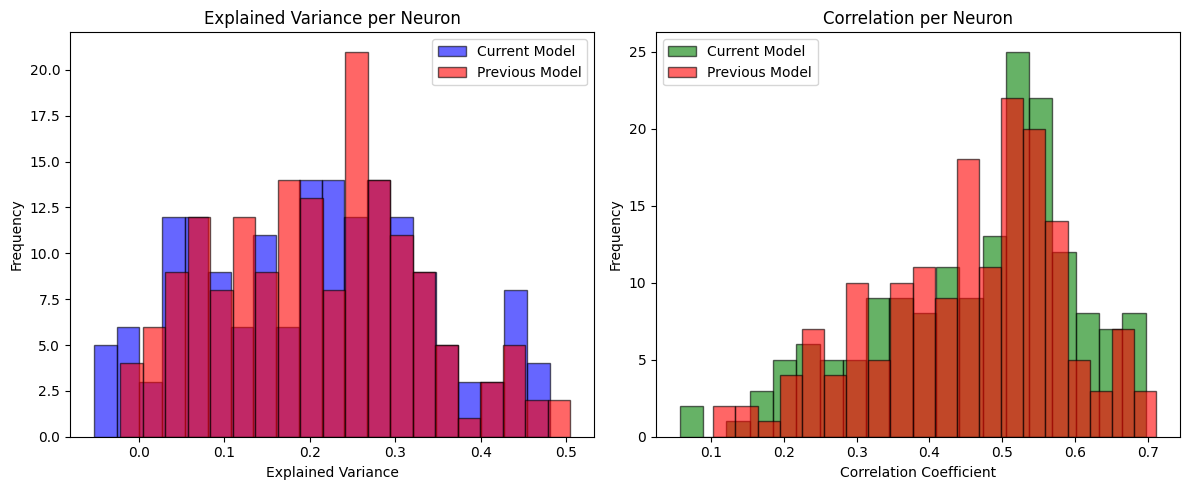

In [28]:
# Evaluate model on the validation set
evaluate_model(deeper_cnn, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_l2, prev_dataloader=val_dataloader)

---

We notice a slight improvement, with the overall explained variance decreasing to 0.2043 but the overall correlation improving to 0.4620. This suggests that our models are still not expressive enough, making it worthwhile to explore the use of pretrained models, which will be addressed in the following section.

---

## Employ a pretrained neural network and finetune it

In this section, we'll try to train 4 models

- CNN model:
    - ResNet50
    - efficientnet_b5 (a bit bigger than ResNet50 and a bit more of parameters)

- Vision transfomers:
    - vit_base_patch16_224
    - vit_tiny_patch16_224

### _ResNet50_

In [29]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [9]:
# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_res = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset_res = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset_res = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_res = DataLoader(train_dataset_res, batch_size=32, shuffle=True)
val_dataloader_res = DataLoader(val_dataset_res, batch_size=32, shuffle=False)
test_dataloader_res = DataLoader(test_dataset_res, batch_size=32, shuffle=False)

In [10]:
# Load Pretrained ResNet50
resnet = models.resnet50(pretrained=True)
# Change the last linear layer to match the number of neurons in the dataset
# Note: The number of neurons in the dataset is 168
resnet.fc = nn.Linear(resnet.fc.in_features, 168)

c:\Users\Qrnqult\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Qrnqult\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

In [33]:
# Train model
train_model(resnet, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1408, Val Loss: 0.1317
Epoch 2/15, Train Loss: 0.1164, Val Loss: 0.1273
Epoch 3/15, Train Loss: 0.1064, Val Loss: 0.1096
Epoch 4/15, Train Loss: 0.0947, Val Loss: 0.0988
Epoch 5/15, Train Loss: 0.0855, Val Loss: 0.0890
Epoch 6/15, Train Loss: 0.0735, Val Loss: 0.0779
Epoch 7/15, Train Loss: 0.0699, Val Loss: 0.0764
Epoch 8/15, Train Loss: 0.0675, Val Loss: 0.0755
Epoch 9/15, Train Loss: 0.0653, Val Loss: 0.0744
Epoch 10/15, Train Loss: 0.0628, Val Loss: 0.0744
Epoch 11/15, Train Loss: 0.0598, Val Loss: 0.0725
Epoch 12/15, Train Loss: 0.0593, Val Loss: 0.0724
Epoch 13/15, Train Loss: 0.0589, Val Loss: 0.0722
Epoch 14/15, Train Loss: 0.0582, Val Loss: 0.0721
Epoch 15/15, Train Loss: 0.0579, Val Loss: 0.0719


[Current Model] Overall explained variance: 0.4231
[Current Model] Overall correlation: 0.6379
[Previous Model] Overall explained variance: 0.2043
[Previous Model] Overall correlation: 0.4620


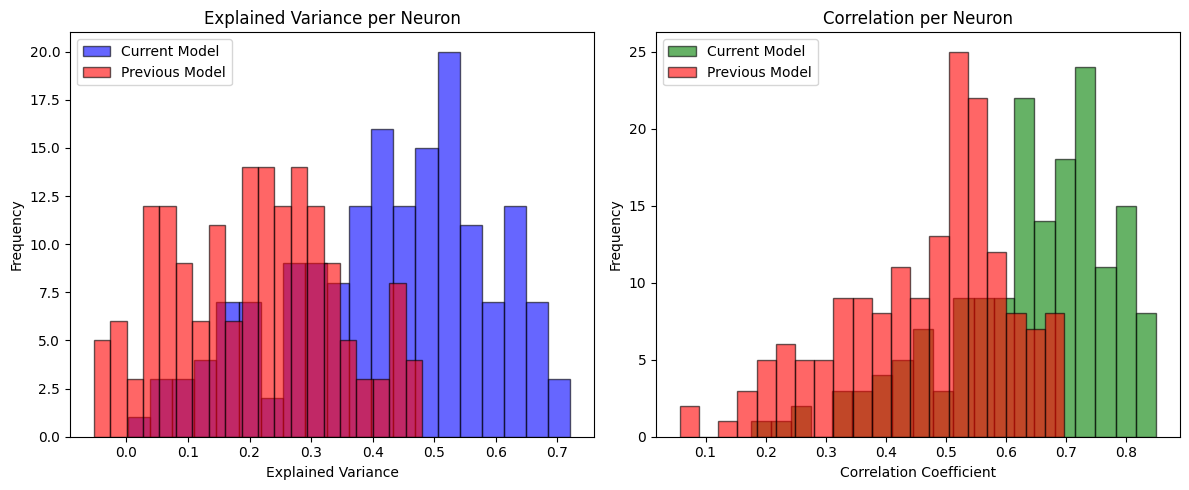

In [34]:
# Evaluate model on the validation set
evaluate_model(resnet, val_dataloader_res, spikes_val, device="cpu",
               prev_model=deeper_cnn, prev_dataloader=val_dataloader)

---

All right! The explained variance improved significantly to 0.4231, and the correlation coefficient increased to 0.6379. This is a substantial improvement, showing that using a pretrained ResNet50 is highly promising. Let's try another model to see if we can achieve even better results.

---

### _efficientnet_b5_

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [12]:
from timm import create_model
eff_res = create_model('efficientnet_b5', pretrained=True)
# Replace the final classifier layer to output 168 neurons
eff_res.classifier = nn.Linear(eff_res.classifier.in_features, 168)

In [37]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(eff_res.parameters(), lr=learning_rate)

In [38]:
train_model(eff_res, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1113, Val Loss: 0.1128
Epoch 2/15, Train Loss: 0.0889, Val Loss: 0.0895
Epoch 3/15, Train Loss: 0.0805, Val Loss: 0.0896
Epoch 4/15, Train Loss: 0.0738, Val Loss: 0.0777
Epoch 5/15, Train Loss: 0.0691, Val Loss: 0.0798
Epoch 6/15, Train Loss: 0.0590, Val Loss: 0.0662
Epoch 7/15, Train Loss: 0.0535, Val Loss: 0.0652
Epoch 8/15, Train Loss: 0.0510, Val Loss: 0.0646
Epoch 9/15, Train Loss: 0.0488, Val Loss: 0.0645
Epoch 10/15, Train Loss: 0.0472, Val Loss: 0.0644
Epoch 11/15, Train Loss: 0.0449, Val Loss: 0.0642
Epoch 12/15, Train Loss: 0.0440, Val Loss: 0.0642
Epoch 13/15, Train Loss: 0.0438, Val Loss: 0.0643
Epoch 14/15, Train Loss: 0.0436, Val Loss: 0.0643
Epoch 15/15, Train Loss: 0.0431, Val Loss: 0.0644


[Current Model] Overall explained variance: 0.4642
[Current Model] Overall correlation: 0.6706
[Previous Model] Overall explained variance: 0.4231
[Previous Model] Overall correlation: 0.6379


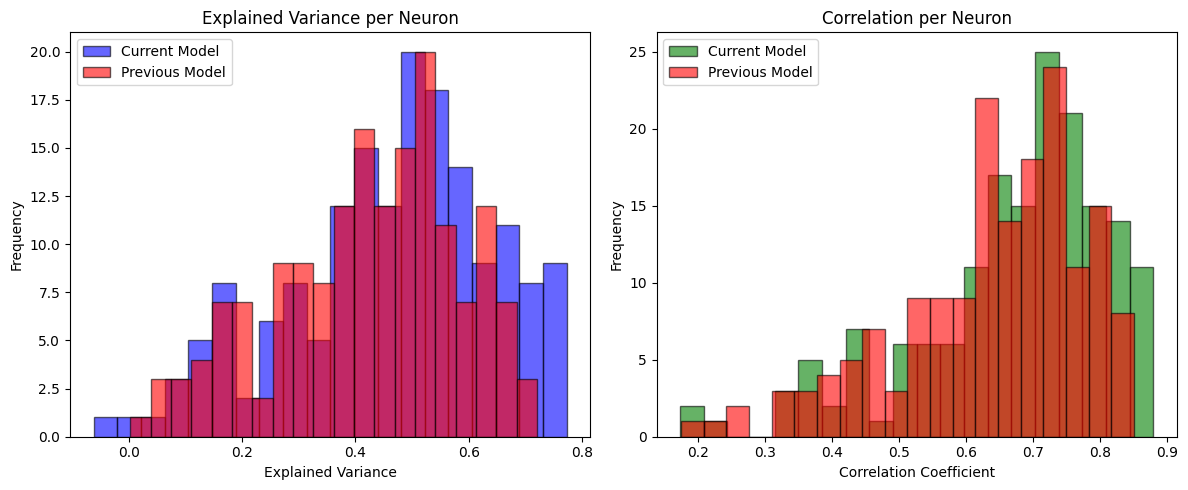

In [39]:
evaluate_model(eff_res, val_dataloader_res, spikes_val, device="cpu",
               prev_model=resnet, prev_dataloader=val_dataloader_res)

In [40]:
from utils import evaluate_model_main_comp

[Current Model] Overall explained variance: 0.4642
[Current Model] Overall correlation: 0.6706
[Previous Model] Overall explained variance: 0.4231
[Previous Model] Overall correlation: 0.6379
[First Model] Overall explained variance: 0.2043
[First Model] Overall correlation: 0.4620


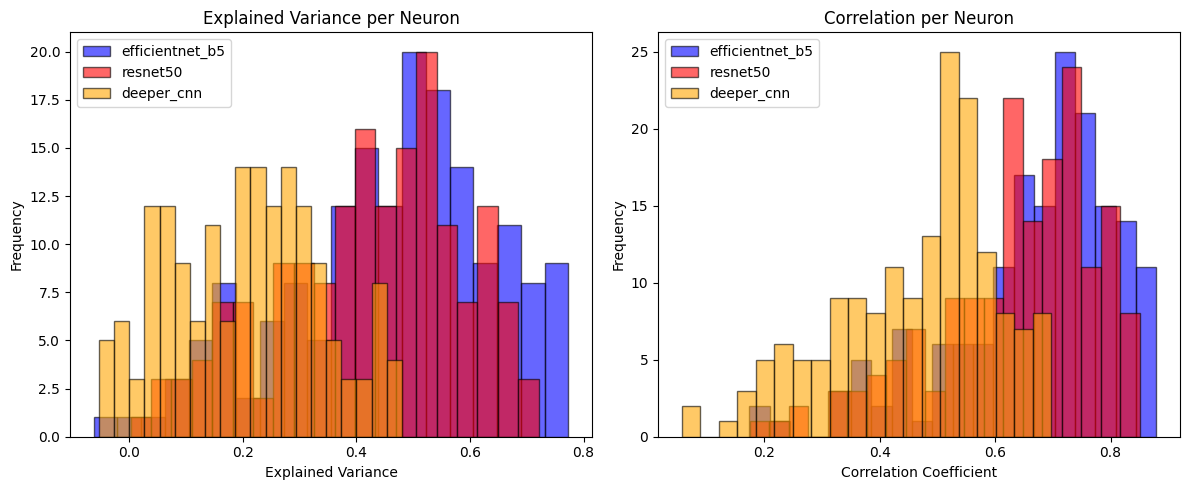

In [41]:
evaluate_model_main_comp(eff_res, val_dataloader_res, spikes_val, "cpu", resnet, val_dataloader_res, deeper_cnn, val_dataloader)

In [42]:
torch.save(eff_res.state_dict(), 'efficientnet_b5.pth')

---

The overall explained variance increased to 0.4642, and the overall correlation improved to 0.6706. As an intermediate conclusion, the slightly larger size (~100MB for ResNet50 and ~120MB for EfficientNet-B5) and the more recent architecture of EfficientNet-B5 provide a slight improvement in performance. This improvement is not a huge gap compared to resnet50, but is still significant as we can see on the graph right above. Another promising direction to explore is transformer models.

---

### _vit_base_patch16_224 (Vision transformer)_

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [44]:
from timm import create_model

# Load a pretrained ViT model (e.g., base model)
vit_base = create_model('vit_base_patch16_224', pretrained=True)

# Replace the final classification head with a linear layer for 168 outputs
vit_base.head = nn.Linear(vit_base.head.in_features, 168)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [45]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(vit_base.parameters(), lr=learning_rate)

In [46]:
train_model(vit_base, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=10, device=device)

Epoch 1/10, Train Loss: 0.1921, Val Loss: 0.1426
Epoch 2/10, Train Loss: 0.1377, Val Loss: 0.1429
Epoch 3/10, Train Loss: 0.1362, Val Loss: 0.1392
Epoch 4/10, Train Loss: 0.1351, Val Loss: 0.1380
Epoch 5/10, Train Loss: 0.1342, Val Loss: 0.1377
Epoch 6/10, Train Loss: 0.1301, Val Loss: 0.1334
Epoch 7/10, Train Loss: 0.1292, Val Loss: 0.1330
Epoch 8/10, Train Loss: 0.1287, Val Loss: 0.1337
Epoch 9/10, Train Loss: 0.1288, Val Loss: 0.1324
Epoch 10/10, Train Loss: 0.1279, Val Loss: 0.1323


[Current Model] Overall explained variance: 0.0569
[Current Model] Overall correlation: 0.2196
[Previous Model] Overall explained variance: 0.4642
[Previous Model] Overall correlation: 0.6706


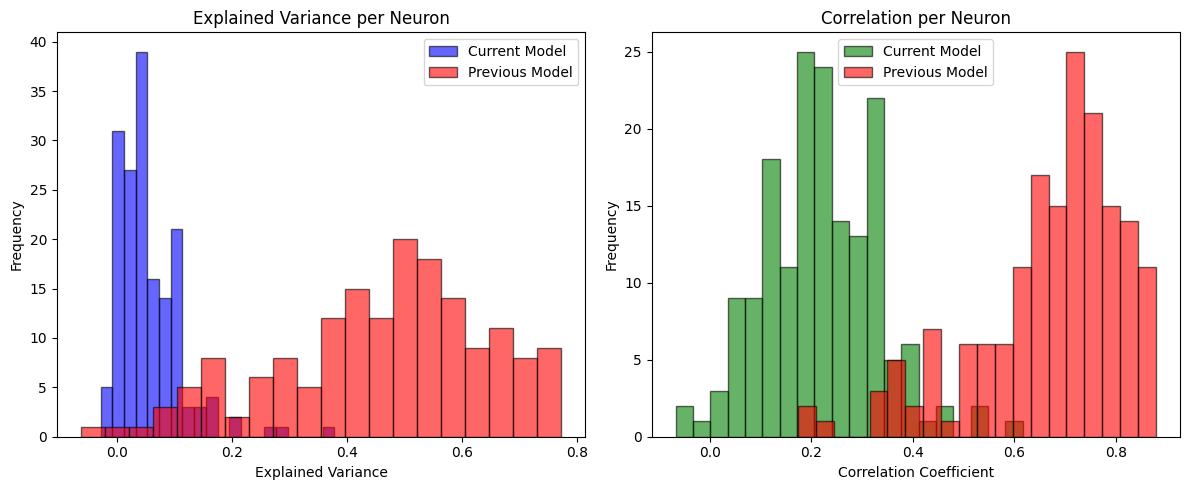

In [47]:
evaluate_model(vit_base, val_dataloader_res, spikes_val, device="cpu",
               prev_model=eff_res, prev_dataloader=val_dataloader_res)

---

As we can see here, using a vision transformer leads to a terrible performance. We then try to use vit_tiny, thinking that possibly the size of our dataset is too small compare to the size of the transformer model, knowing that transformer models often require more data to train than CNN models.

---

### _vit_tiny_patch16_224 (Vision transformer)_

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [49]:
from timm import create_model

# Load a pretrained ViT model (e.g., base model)
vit_tiny = create_model('vit_tiny_patch16_224', pretrained=True)

# Replace the final classification head with a linear layer for 168 outputs
vit_tiny.head = nn.Linear(vit_tiny.head.in_features, 168)

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [50]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(vit_tiny.parameters(), lr=learning_rate)

In [51]:
train_model(vit_tiny, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.3314, Val Loss: 0.1462
Epoch 2/15, Train Loss: 0.1383, Val Loss: 0.1420
Epoch 3/15, Train Loss: 0.1376, Val Loss: 0.1390
Epoch 4/15, Train Loss: 0.1358, Val Loss: 0.1378
Epoch 5/15, Train Loss: 0.1333, Val Loss: 0.1386
Epoch 6/15, Train Loss: 0.1255, Val Loss: 0.1305
Epoch 7/15, Train Loss: 0.1211, Val Loss: 0.1267
Epoch 8/15, Train Loss: 0.1148, Val Loss: 0.1240
Epoch 9/15, Train Loss: 0.1094, Val Loss: 0.1191
Epoch 10/15, Train Loss: 0.1029, Val Loss: 0.1179
Epoch 11/15, Train Loss: 0.0957, Val Loss: 0.1147
Epoch 12/15, Train Loss: 0.0939, Val Loss: 0.1149
Epoch 13/15, Train Loss: 0.0929, Val Loss: 0.1147
Epoch 14/15, Train Loss: 0.0919, Val Loss: 0.1144
Epoch 15/15, Train Loss: 0.0911, Val Loss: 0.1141


[Current Model] Overall explained variance: -0.2905
[Current Model] Overall correlation: 0.0892
[Previous Model] Overall explained variance: 0.4642
[Previous Model] Overall correlation: 0.6706


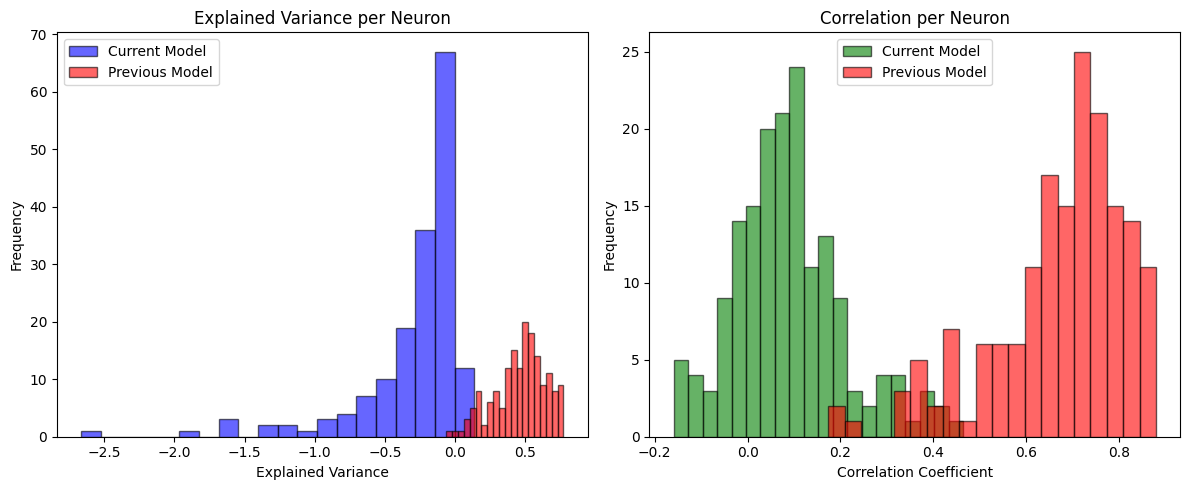

In [52]:
evaluate_model(vit_tiny, val_dataloader_res, spikes_val, device="cpu",
               prev_model=eff_res, prev_dataloader=val_dataloader_res)

---

The performance here is even worse. It looks like the model is not able to predict any neural activity at all. Neural activity in the brain, especially early visual areas like V1, is highly localized and sensitive to spatial structure. Hence, due to the difference of architecture that makes ViTs not assuming locality the same way, they might fail to capture the kinds of spatial features that are actually predictive of neural responses.

---

## Train a neural network for object recognition while predicting neural activity.

In this section, we'll train two model. For both models, we'll finetune ResNet50 using two objectives. The difference between the two models is how we'll balance the two objectives

1. Give the same weight (in term on how we balance) between both models
2. Give 0.3 coeff for the label prediction objective and 1 coeff to neural activity objective

### _Equal weight to both objectives_

In [53]:
number_classes = np.unique(objects_train).shape[0]
print('Number of classes in the dataset: {}'.format(number_classes))

Number of classes in the dataset: 64


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [55]:
print(objects_train)

['face6', 'table3', 'face3', 'face2', 'lioness', 'turtle', 'turtle', 'airplane3', 'cow', 'car_alfa', 'table2', 'ship1', 'car_bora', 'airplane3', 'face6', 'chair4', 'airplane0', 'airplane6', 'chair2', 'car_alfa', 'gorilla', 'chair4', 'raspberry', 'pear', 'chair5', 'face0', 'table5', 'table1', 'airplane5', 'airplane2', 'table7', 'chair0', 'chair7', 'face7', 'car_beetle', 'ship7', 'table0', 'chair7', 'airplane4', 'car_z3', 'chair7', 'lioness', 'table5', 'walnut', 'chair5', 'chair4', 'chair3', 'elephant', 'car_alfa', 'table4', 'car_clio', 'ship2', 'apple', 'airplane2', 'face1', 'chair7', 'watermelon', 'airplane0', 'walnut', 'watermelon', 'dog', 'airplane7', 'ship1', 'apple', 'ship7', 'ship6', 'ship2', 'pear', 'car_bmw', 'car_alfa', 'face0', 'ship1', 'ship7', 'table1', 'car_bora', 'car_alfa', 'watermelon', 'pear', 'car_celica', 'apple', 'chair7', 'table0', 'car_clio', 'airplane7', 'car_beetle', 'apricot', 'table1', 'chair0', 'car_bora', 'hedgehog', 'ship6', 'airplane4', 'chair2', 'car_z3', 

In [56]:
def string_to_label(objects, label_dict):
    """
    Convert object names to labels.

    Args:
        objects (numpy array): Array of object names.

    Returns:
        numpy array: Array of labels corresponding to the object names.
    """
    labels = np.array([label_dict[obj] for obj in objects])
    return labels

In [57]:
# Outputs the unique labels for the objects
unique_objects = np.unique(objects_train)
# Create a dictionary to map object names to labels
label_dict = {obj: idx for idx, obj in enumerate(unique_objects)}

# Convert object names to labels
objects_train_labels = string_to_label(objects_train, label_dict)
objects_val_labels = string_to_label(objects_val, label_dict)
objects_test_labels = string_to_label(objects_test, label_dict)

In [58]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, objects=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction with additional objects info.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            objects (numpy array, optional): Additional information (e.g., object labels). Default is None.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.objects = torch.from_numpy(objects).long() if objects is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None
        object_info = self.objects[idx] if self.objects is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        # Return the image, neural activity, and object info if available
        if neural_activity is not None and object_info is not None:
            return img, neural_activity, object_info
        else:
            return img

# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_bi = ITNeuralActivity(stimulus_train, spikes_train, objects_train_labels, transform=transform)
val_dataset_bi = ITNeuralActivity(stimulus_val, spikes_val, objects_val_labels, transform=transform)
test_dataset_bi = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_bi = DataLoader(train_dataset_bi, batch_size=32, shuffle=True)
val_dataloader_bi = DataLoader(val_dataset_bi, batch_size=32, shuffle=False)
test_dataloader_bi = DataLoader(test_dataset_bi, batch_size=32, shuffle=False)

In [59]:
class MultiTaskModel(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskModel, self).__init__()

        # Remove the final fully connected layer (fc)
        self.base_model = base_model
        self.base_model.fc = nn.Identity()

        # Forward pass through the model with a dummy input to get the feature map size
        dummy_input = torch.zeros(1, 3, 224, 224)  # Example input with batch size 1 and 3 RGB channels
        with torch.no_grad():
            features = self.base_model(dummy_input)

        # Get the size of the features from the last convolutional block
        # We need this because the model has to have a fc_in_features that matches the output of the base model
        self.fc_in_features = features.numel()  # This will give us the flattened size

        # Task-specific heads
        self.task1_head = nn.Linear(self.fc_in_features, 168)  # For continuous output (neural activity)
        self.task2_head = nn.Linear(self.fc_in_features, 64)   # For classification (64 classes in our case)

    def forward(self, x):
        # Shared layers
        features = self.base_model(x)  # Output from ResNet (before the last fully connected layer)

        # Flatten the features to pass to the heads
        features = features.view(features.size(0), -1)  # Flatten the feature map

        # Task-specific outputs
        task1_output = self.task1_head(features)
        task2_output = self.task2_head(features)

        return task1_output, task2_output

# Load the ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Instantiate the multi-task model
model_multi_1 = MultiTaskModel(resnet50)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
criterion_activity = nn.MSELoss()  # For continuous neural activity
criterion_label = nn.CrossEntropyLoss()  # For classification task

learning_rate = 0.001
optimizer = optim.Adam(model_multi_1.parameters(), lr=learning_rate)

In [61]:
from utils import train_model_biobj

In [62]:
# Train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
coef_label = 1
train_model_biobj(model_multi_1, train_dataloader_bi, val_dataloader_bi, criterion_activity, criterion_label, coef_label, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 3.7551, Val Loss: 3.8154
Epoch 2/20, Train Loss: 2.7938, Val Loss: 10.0914
Epoch 3/20, Train Loss: 2.4487, Val Loss: 2.2685
Epoch 4/20, Train Loss: 2.1739, Val Loss: 2.7336
Epoch 5/20, Train Loss: 1.9025, Val Loss: 2.1058
Epoch 6/20, Train Loss: 1.3413, Val Loss: 1.2532
Epoch 7/20, Train Loss: 1.0856, Val Loss: 1.1612
Epoch 8/20, Train Loss: 0.9654, Val Loss: 1.1075
Epoch 9/20, Train Loss: 0.8446, Val Loss: 1.0230
Epoch 10/20, Train Loss: 0.7103, Val Loss: 0.9727
Epoch 11/20, Train Loss: 0.6239, Val Loss: 0.9216
Epoch 12/20, Train Loss: 0.5916, Val Loss: 0.9128
Epoch 13/20, Train Loss: 0.5677, Val Loss: 0.9170
Epoch 14/20, Train Loss: 0.5530, Val Loss: 0.8999
Epoch 15/20, Train Loss: 0.5439, Val Loss: 0.9043
Epoch 16/20, Train Loss: 0.5391, Val Loss: 0.9018
Epoch 17/20, Train Loss: 0.5295, Val Loss: 0.8957
Epoch 18/20, Train Loss: 0.5395, Val Loss: 0.8961
Epoch 19/20, Train Loss: 0.5225, Val Loss: 0.8926
Epoch 20/20, Train Loss: 0.5232, Val Loss: 0.8979


---

For the first model, where we gave equal weight to both objectives, the overall explained variance was 0.1988, and the overall correlation was 0.4348 (as shown in the next graph of this notebook). The performance on training of both objectives seems to decrease compare to the original ResNet model, trained on the unique objective to predict neural activity. We then need to try to balance the objectives differently and study if it makes a difference in predicting neural activity.

---

### _Weight 0.3 to the label prediction objective & 1 to the neural activity objective_

Here we'll try to balance the objective a bit differently

In [64]:
# Train model
train_dataloader_bi = DataLoader(train_dataset_bi, batch_size=32, shuffle=True)
val_dataloader_bi = DataLoader(val_dataset_bi, batch_size=32, shuffle=False)
test_dataloader_bi = DataLoader(test_dataset_bi, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
coef_label = 0.3
# Load the ResNet50 model
resnet50_03 = models.resnet50(pretrained=True)

# Instantiate the multi-task model
model_multi_0_3 = MultiTaskModel(resnet50_03)

criterion_activity = nn.MSELoss()  # For continuous neural activity
criterion_label = nn.CrossEntropyLoss()  # For classification task

learning_rate = 0.001
optimizer = optim.Adam(model_multi_0_3.parameters(), lr=learning_rate)

train_model_biobj(model_multi_0_3, train_dataloader_bi, val_dataloader_bi, criterion_activity, criterion_label, coef_label, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 1.0595, Val Loss: 1.1084
Epoch 2/20, Train Loss: 0.7920, Val Loss: 0.9835
Epoch 3/20, Train Loss: 0.6533, Val Loss: 0.7809
Epoch 4/20, Train Loss: 0.5669, Val Loss: 1.1424
Epoch 5/20, Train Loss: 0.5012, Val Loss: 1.1485
Epoch 6/20, Train Loss: 0.3448, Val Loss: 0.3510
Epoch 7/20, Train Loss: 0.2775, Val Loss: 0.3303
Epoch 8/20, Train Loss: 0.2530, Val Loss: 0.3302
Epoch 9/20, Train Loss: 0.2239, Val Loss: 0.3063
Epoch 10/20, Train Loss: 0.2014, Val Loss: 0.3080
Epoch 11/20, Train Loss: 0.1825, Val Loss: 0.2894
Epoch 12/20, Train Loss: 0.1770, Val Loss: 0.2911
Epoch 13/20, Train Loss: 0.1723, Val Loss: 0.2898
Epoch 14/20, Train Loss: 0.1721, Val Loss: 0.2907
Epoch 15/20, Train Loss: 0.1684, Val Loss: 0.2915
Epoch 16/20, Train Loss: 0.1665, Val Loss: 0.2883
Epoch 17/20, Train Loss: 0.1659, Val Loss: 0.2929
Epoch 18/20, Train Loss: 0.1670, Val Loss: 0.2889
Epoch 19/20, Train Loss: 0.1645, Val Loss: 0.2889
Epoch 20/20, Train Loss: 0.1647, Val Loss: 0.2867


Overall explained variance biobjective weight 1: 0.1988
Overall correlation biobjective weight 1: 0.4348
Overall explained variance biobjective weight 0.3: 0.3156
Overall correlation biobjective weight 0.3: 0.5506
Overall explained variance resnet: 0.4642
Overall correlation resnet: 0.6706


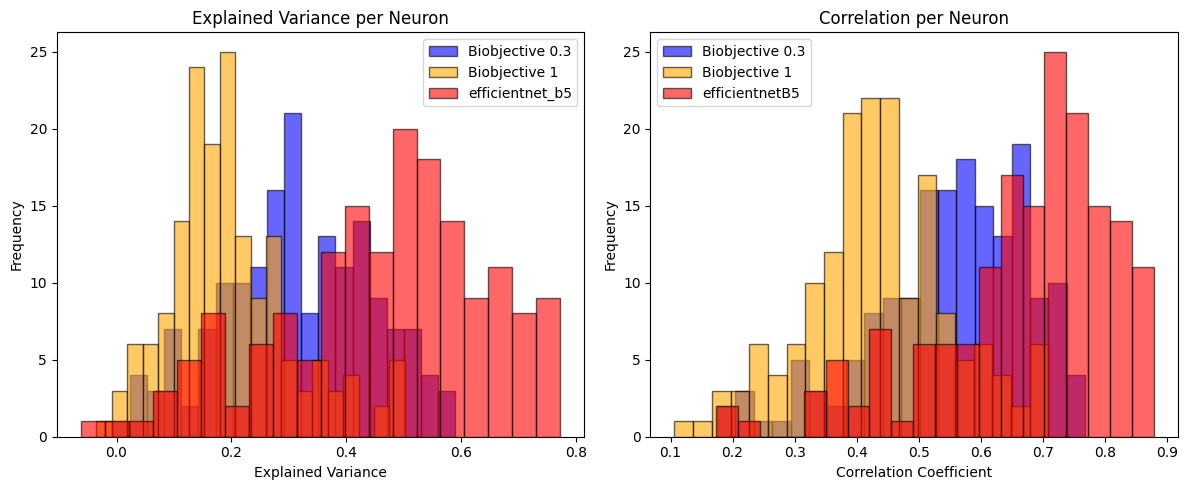

In [ ]:
from utils import evaluate_model_bi
evaluate_model_bi(model_multi_0_3, val_dataloader_bi, spikes_val, "cpu", model_multi_1, eff_res, val_dataloader_res)

---

For the second model, where we assigned a weight of 0.3 to the label prediction objective and 1 to the neural activity objective, the overall explained variance improved to 0.3156, and the overall correlation increased to 0.5506, suggesting that prioritizing the neural activity objective leads to better performance. Indeed, the original ResNet model, trained solely on predicting neural acitivity led to better performance, with an overall explained variance of 0.4642 and an overall correlation of 0.6706. The graphics suggest the idea that the less we train on the label prediction objective, the better the model is at predicting neural activity.

---

## Employ a pretrained neural network and finetune it 2.0

We've seen so far that the most promising method is to use a pretrained neural network and finetune it. So far, the models that worked well were ResNet50 and efficientnet_b5. In this last attempt to improve our model, we test DenseNet-201, coupled with an optimized scheduler. We also tried to use pnasnet5large. The results of pnasnet5large ended beeing in between the results for efficientnet_b5 and the results for efficientnet_b5.

### DenseNet-201

In [6]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device='cpu', scheduler=None):
    """
    Train the model and validate it after each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        loss_function (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.to(device)

    from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
    swa_model     = AveragedModel(model)
    swa_start_ep  = 5                      # start averaging once val loss flattens
    swa_scheduler = SWALR(optimizer, swa_lr=1e-4)

    # Learning rate scheduler
    if scheduler is None:
        # Use StepLR scheduler with step size of 5 and gamma of 0.1
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, spikes in train_dataloader:
            images, spikes = images.to(device), spikes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, spikes)

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, spikes in val_dataloader:
                images, spikes = images.to(device), spikes.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_function(outputs, spikes)

                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        if epoch >= swa_start_ep:
          swa_model.update_parameters(model)
          swa_scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, "
              f"Val Loss: {val_loss/len(val_dataloader):.4f}")

        # Stop training if loss becomes NaN or Inf
        if torch.isnan(torch.tensor(train_loss)) or torch.isinf(torch.tensor(train_loss)):
            print("Training stopped due to unstable loss (NaN or Inf).")
            break

    # --- SWA finalisation (after the epoch loop) ---
    update_bn(train_dataloader, swa_model, device=device)

    # If swa_model came from a DataParallel‑wrapped network,
    # keep the inner module; otherwise keep swa_model itself.
    model = swa_model.module if hasattr(swa_model, "module") else swa_model


In [ ]:
from utils import compute_ev_and_corr

def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 18,415,656


In [ ]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

base_lr     = 1e-3        # same as now
num_epochs  = 15          # keep your 15‑epoch budget
warmup_ep   = 2

warmup = LinearLR(optimizer,
                  start_factor=0.1,      # 0.1 × base_lr
                  end_factor=1.0,
                  total_iters=warmup_ep)

cosine = CosineAnnealingLR(optimizer,
                           T_max=num_epochs - warmup_ep,
                           eta_min=base_lr * 1e-3)   # ends 1000× lower

scheduler = SequentialLR(optimizer,
                         schedulers=[warmup, cosine],
                         milestones=[warmup_ep])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler = scheduler)


Epoch 1/10, Train Loss: 0.1200, Val Loss: 0.0911


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train Loss: 0.0865, Val Loss: 0.0803
Epoch 3/10, Train Loss: 0.0780, Val Loss: 0.0825
Epoch 4/10, Train Loss: 0.0664, Val Loss: 0.0778
Epoch 5/10, Train Loss: 0.0570, Val Loss: 0.0737
Epoch 6/10, Train Loss: 0.0500, Val Loss: 0.0934
Epoch 7/10, Train Loss: 0.0432, Val Loss: 0.0665
Epoch 8/10, Train Loss: 0.0354, Val Loss: 0.0648
Epoch 9/10, Train Loss: 0.0292, Val Loss: 0.0610
Epoch 10/10, Train Loss: 0.0227, Val Loss: 0.0609


Overall explained variance: 0.4930
Overall correlation: 0.6967


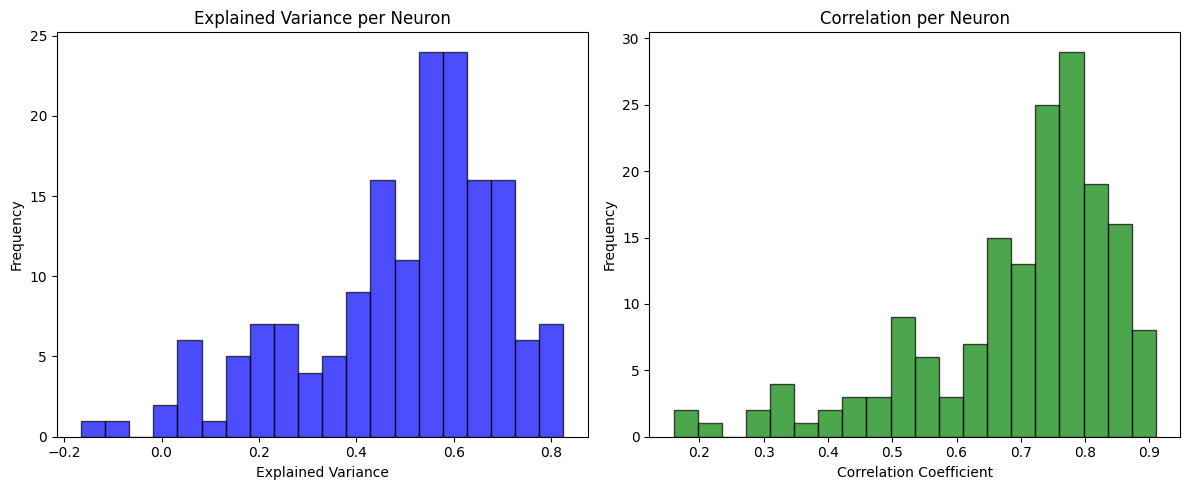

In [ ]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")

Reducing the epochs led to better performace, less overfitting!
Moreover, it seems like moving to a linear warm-up scheduler early helps the mode, other optimizers were used but it seems that adam is the best option for our implemetantion.

---

Compared to EfficientNet-B5, this model improved our results from an explained variance of 0.4642 to 0.4930 and a correlation of 0.6706 to 0.6967, marking the best performance achieved in this project. These findings suggest that improving neural prediction does not necessarily require larger models, but rather the right architectural choice."

---

Just for creating the comparison, we loaded the weights trained right before. 

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cpu()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
model.load_state_dict(torch.load('./models/DenseNet201.pth'))

Model parameters: 18,415,656


<All keys matched successfully>

[Current Model] Overall explained variance: 0.4937
[Current Model] Overall correlation: 0.6971
[Previous Model] Overall explained variance: 0.4642
[Previous Model] Overall correlation: 0.6706


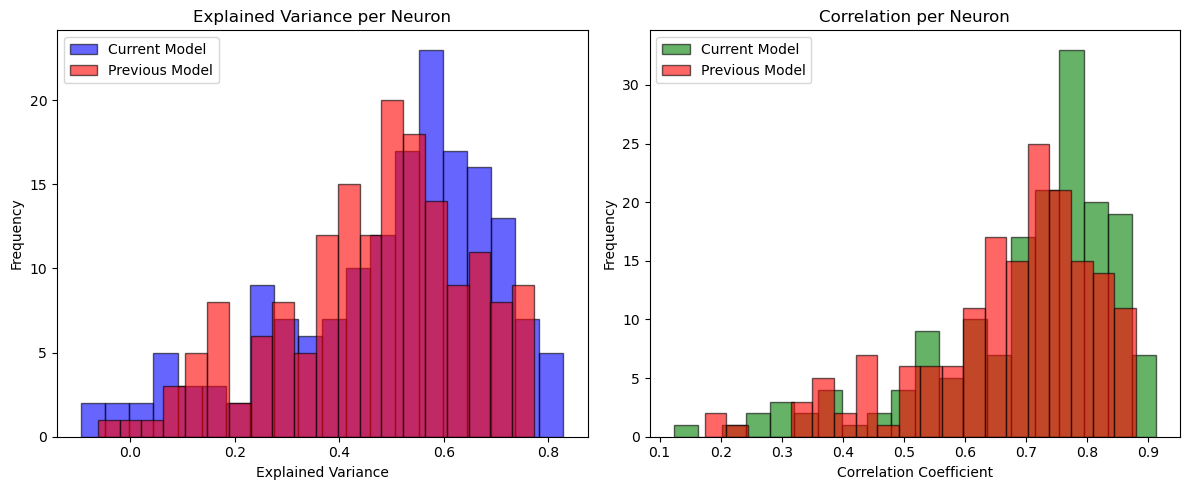

In [ ]:
evaluate_model(model, val_dataloader, spikes_val, device="cpu",
               prev_model=eff_res, prev_dataloader=val_dataloader_res)

---

Here we see a comparison between the densenet model and the efficient_net_b5. We see that the first outperforme the latter (EV 0.4937 against 0.4642 / Correlation 0.6971 against 0.6706) 

---

### Pnasnet5large

In [ ]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone, "classifier"):          # many EfficientNet‑style models
    in_features = backbone.classifier.in_features
    backbone.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "fc"):                # ResNet‑style
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone.head.in_features
    backbone.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "last_linear"):       # Inception / PNASNet
    in_features = backbone.last_linear.in_features
    backbone.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3 = backbone.cuda()
print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3.parameters()):,}")


PNASNet‑5 Large parameters: 82,462,596


In [ ]:
optimizer = optim.AdamW(model3.parameters(), lr=learning_rate)

# NOTE: using the same loss function as before (MSE)

In [ ]:
# Using scheduler defined before...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model3, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device, scheduler=scheduler)

Epoch 1/15, Train Loss: 0.1184, Val Loss: 0.1085
Epoch 2/15, Train Loss: 0.0970, Val Loss: 0.0957
Epoch 3/15, Train Loss: 0.0849, Val Loss: 0.0888
Epoch 4/15, Train Loss: 0.0762, Val Loss: 0.0796
Epoch 5/15, Train Loss: 0.0706, Val Loss: 0.0784
Epoch 6/15, Train Loss: 0.0652, Val Loss: 0.0771
Epoch 7/15, Train Loss: 0.0609, Val Loss: 0.0730
Epoch 8/15, Train Loss: 0.0573, Val Loss: 0.0678
Epoch 9/15, Train Loss: 0.0533, Val Loss: 0.0663
Epoch 10/15, Train Loss: 0.0495, Val Loss: 0.0669
Epoch 11/15, Train Loss: 0.0455, Val Loss: 0.0638
Epoch 12/15, Train Loss: 0.0419, Val Loss: 0.0621
Epoch 13/15, Train Loss: 0.0382, Val Loss: 0.0613
Epoch 14/15, Train Loss: 0.0355, Val Loss: 0.0601
Epoch 15/15, Train Loss: 0.0332, Val Loss: 0.0600


Overall explained variance: 0.4894
Overall correlation: 0.6890


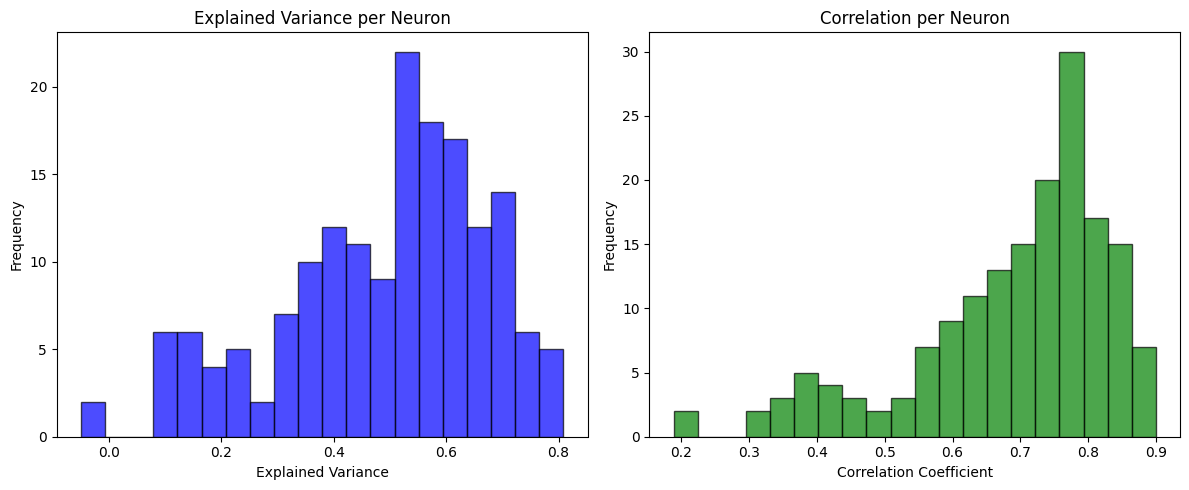

In [ ]:
# Evaluate model on the validation set
evaluate_model(model3, val_dataloader, spikes_val, device="cpu")


---

### **Model Performance Summary**

| Model           | Overall Explained Variance | Overall Correlation |
| --------------- | -------------------------- | ------------------- |
| **DenseNet201** | **0.4937**                 | **0.6971**          |
| PNASNet-5 Large | 0.4894                     | 0.6890              |
| efficientnet_b5 | 0.4642                     | 0.6706              |

---

### **Discussion**

Among the evaluated architectures, **DenseNet201** yields the strongest performance, achieving the highest explained variance and correlation with ground truth neural responses. Its densely connected layers likely promote richer feature reuse and more robust gradient flow, making it well-suited for capturing the structure of neural activity.

**PNASNet-5 Large** closely follows DenseNet201, with only marginally lower scores. This suggests that its architecture—discovered via neural architecture search—is effective at extracting features that generalize well to neural data, even though it was not explicitly designed for this task.

In short:

* **DenseNet201** provides the best overall alignment with neural activity.
* **PNASNet-5 Large** is a strong alternative, nearly matching DenseNet's performance.

---

## Utilize different pretrained models with the task-driven modeling approach

In this section, we try to predict the neural activity by fitting a linear regression to the weigths of the pretrained layers of different layers like for the part 2 of week 6. In week 6, we used the pretrained weigths of ResNet 50. Here, we use the pretrained weights of the layers of DenseNet201, of ResNet152 and of PNASNet-5 Large.

In [ ]:
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

In [ ]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### _Custom Stimuli Dataset Class Definition_

In [ ]:
class StimuliDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading visual stimuli and optional neural response data.

    Parameters
    ----------
    stimuli : np.ndarray or list
        A collection of image stimuli, expected as a NumPy array or list of arrays.
    responses : np.ndarray or list, optional
        Corresponding neural response vectors for each stimulus. If None, dataset returns only stimuli.
    transform : callable, optional
        A function/transform to apply to each stimulus (e.g., normalization).

    Methods
    -------
    __len__():
        Returns the number of samples in the dataset.

    __getitem__(idx):
        Returns the transformed stimulus and corresponding response (if available) at the given index.
    """

    def __init__(self, stimuli, responses=None, transform=None):
        self.stimuli = stimuli
        self.responses = responses
        self.transform = transform

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        x = self.stimuli[idx]
        if self.transform:
            x = self.transform(torch.tensor(x).float())
        return (x, self.responses[idx]) if self.responses is not None else x

#### _Data Preparation: Datasets, Transforms, and DataLoaders_

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = StimuliDataset(stimulus_train, spikes_train, transform=transform)
val_dataset = StimuliDataset(stimulus_val, spikes_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

#### _Activation Extraction Utility Function_

In [ ]:
def extract_activations(model, loader, layer_name):
    """
    Extracts and flattens activations from a specified layer of a model for all inputs in a DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model from which to extract activations.
    loader : torch.utils.data.DataLoader
        DataLoader providing input data in batches.
    layer_name : str
        Name of the layer (as registered in model.named_modules()) to hook and extract activations from.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (N, D) where N is the number of samples and D is the flattened activation dimension
        from the specified layer.
    """
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy().reshape(output.size(0), -1))

    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            _ = model(imgs)

    hook.remove()

    return np.concatenate(activations, axis=0)


#### _Visulaization function_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_ev_corr_comparison(model_name, layers_labels, results_pre, results_rand):
    explained_vars_pre = [results_pre[layer]['explained_variance'] for layer in layers_labels]
    correlations_pre = [results_pre[layer]['mean_correlation'] for layer in layers_labels]
    explained_vars_rand = [results_rand[layer]['explained_variance'] for layer in layers_labels]
    correlations_rand = [results_rand[layer]['mean_correlation'] for layer in layers_labels]

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Explained Variance (left axis)
    color_ev_pre = 'tab:blue'
    color_ev_rand = 'tab:cyan'
    ax1.set_xlabel('Layers')
    ax1.set_ylabel('Explained Variance', color=color_ev_pre)
    ax1.plot(layers_labels, explained_vars_pre, color=color_ev_pre, marker='o', label='Explained Variance (Pretrained)')
    ax1.plot(layers_labels, explained_vars_rand, color=color_ev_rand, marker='o', linestyle='--', label='Explained Variance (Random)')
    ax1.tick_params(axis='y', labelcolor=color_ev_pre)

    # Mean Correlation (right axis)
    ax2 = ax1.twinx()
    color_corr_pre = 'tab:green'
    color_corr_rand = 'tab:olive'
    ax2.set_ylabel('Mean Correlation', color=color_corr_pre)
    ax2.plot(layers_labels, correlations_pre, color=color_corr_pre, marker='x', label='Mean Correlation (Pretrained)')
    ax2.plot(layers_labels, correlations_rand, color=color_corr_rand, marker='x', linestyle='--', label='Mean Correlation (Random)')
    ax2.tick_params(axis='y', labelcolor=color_corr_pre)

    # Combined legend
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    plt.title(f'Comparison of Pretrained and Random Model Performance across Layers ({model_name})')
    fig.tight_layout()
    plt.show()




def plot_neuron_metrics_hist(model_name, spikes_val, preds_val_pre, preds_val_rand):
    # Explained variance per neuron
    ev_pre = 1 - np.var(spikes_val - preds_val_pre, axis=0) / np.var(spikes_val, axis=0)
    ev_rand = 1 - np.var(spikes_val - preds_val_rand, axis=0) / np.var(spikes_val, axis=0)

    # Pearson correlation per neuron
    corr_pre = [pearsonr(spikes_val[:, i], preds_val_pre[:, i])[0] for i in range(spikes_val.shape[1])]
    corr_rand = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]

    # Plot histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].hist(ev_pre, bins=20, color='tab:blue', alpha=0.7, edgecolor='black')
    axs[0, 0].set_title('Explained Variance per Neuron (Pretrained)')
    axs[0, 0].set_xlabel('Explained Variance')
    axs[0, 0].set_ylabel('Frequency')

    axs[0, 1].hist(ev_rand, bins=20, color='tab:cyan', alpha=0.7, edgecolor='black')
    axs[0, 1].set_title('Explained Variance per Neuron (Random)')
    axs[0, 1].set_xlabel('Explained Variance')
    axs[0, 1].set_ylabel('Frequency')

    axs[1, 0].hist(corr_pre, bins=20, color='tab:green', alpha=0.7, edgecolor='black')
    axs[1, 0].set_title('Correlation per Neuron (Pretrained)')
    axs[1, 0].set_xlabel('Correlation Coefficient')
    axs[1, 0].set_ylabel('Frequency')

    axs[1, 1].hist(corr_rand, bins=20, color='tab:olive', alpha=0.7, edgecolor='black')
    axs[1, 1].set_title('Correlation per Neuron (Random)')
    axs[1, 1].set_xlabel('Correlation Coefficient')
    axs[1, 1].set_ylabel('Frequency')

    plt.suptitle(f'Neuron-Level Performance Comparison: Pretrained vs Random ({model_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### Densenet201_

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone_pre = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone_pre.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone_pre.classifier = nn.Linear(in_features, n_neurons)

model_pre = backbone_pre.cuda()
print(f"Model parameters: {sum(p.numel() for p in model_pre.parameters()):,}")
layers = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

results = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act = extract_activations(model_pre, train_loader, layer)
    val_act = extract_activations(model_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pcs = pca.fit_transform(train_act)
    X_val_pcs = pca.transform(val_act)

    # Linear Regression
    lr = LinearRegression().fit(X_train_pcs, spikes_train)
    preds_val = lr.predict(X_val_pcs)

    # Evaluation metrics
    ev = explained_variance_score(spikes_val, preds_val)
    correlations = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr = np.mean(correlations)

    results[layer] = {'explained_variance': ev, 'mean_correlation': avg_corr}

    print(f"{layer} | EV: {ev:.4f}, Mean Corr: {avg_corr:.4f}")


Model parameters: 18,415,656
Processing features.conv0
features.conv0 | EV: -0.0760, Mean Corr: 0.2165
Processing features.denseblock1
features.denseblock1 | EV: 0.2242, Mean Corr: 0.4719
Processing features.denseblock2
features.denseblock2 | EV: 0.2823, Mean Corr: 0.5306
Processing features.denseblock3
features.denseblock3 | EV: 0.3871, Mean Corr: 0.6178
Processing features.denseblock4
features.denseblock4 | EV: 0.3929, Mean Corr: 0.6253
Processing features.norm5
features.norm5 | EV: 0.3228, Mean Corr: 0.5724


#### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized Densenet201_

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet backbone NO Pretrainig
backbone_rand = densenet201(weights=None)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone_rand.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone_rand.classifier = nn.Linear(in_features, n_neurons)

model_rand = backbone_rand.cuda()
print(f"Model parameters: {sum(p.numel() for p in model_pre.parameters()):,}")
layers = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

results_rand = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand = extract_activations(model_rand, train_loader, layer)
    val_act_rand  = extract_activations(model_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand  = pca_rand .fit_transform(train_act_rand)
    X_val_pcs_rand  = pca_rand .transform(val_act_rand)

    # Linear Regression
    lr_rand  = LinearRegression().fit(X_train_pcs_rand , spikes_train )
    preds_val_rand  = lr_rand .predict(X_val_pcs_rand )

    # Evaluation metrics
    ev_rand  = explained_variance_score(spikes_val, preds_val_rand )
    correlations_rand  = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand  = np.mean(correlations_rand )

    results_rand[layer] = {'explained_variance': ev_rand, 'mean_correlation': avg_corr_rand}

    print(f"{layer} | EV: {ev_rand:.4f}, Mean Corr: {avg_corr_rand:.4f}")



Model parameters: 18,415,656
Processing features.conv0
features.conv0 | EV: -0.0790, Mean Corr: 0.2179
Processing features.denseblock1
features.denseblock1 | EV: 0.1814, Mean Corr: 0.4376
Processing features.denseblock2
features.denseblock2 | EV: 0.2176, Mean Corr: 0.4626
Processing features.denseblock3
features.denseblock3 | EV: 0.2350, Mean Corr: 0.4707
Processing features.denseblock4
features.denseblock4 | EV: 0.2289, Mean Corr: 0.4676
Processing features.norm5
features.norm5 | EV: 0.2324, Mean Corr: 0.4714


In [ ]:
print("results_rand keys:", results_rand.keys())

results_rand keys: dict_keys(['features.conv0', 'features.denseblock1', 'features.denseblock2', 'features.denseblock3', 'features.denseblock4', 'features.norm5'])


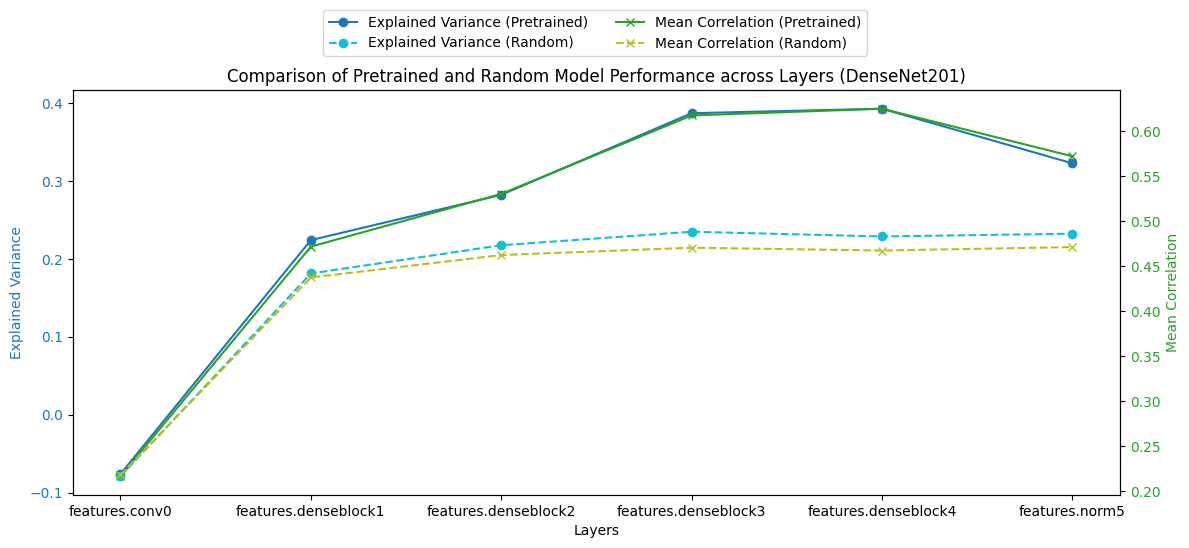

In [ ]:
layers_labels = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

plot_ev_corr_comparison("DenseNet201", layers_labels, results, results_rand)


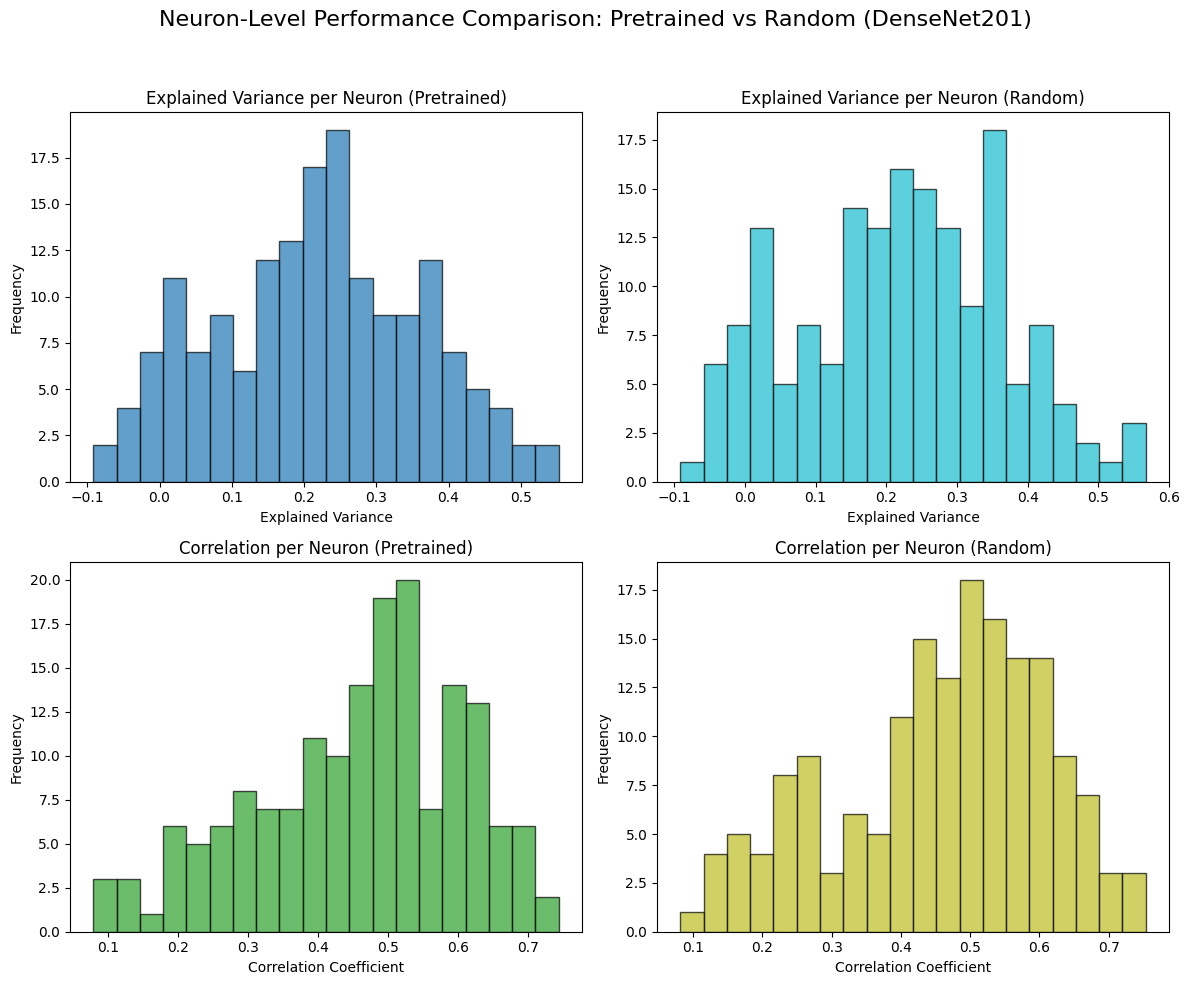

In [ ]:
plot_neuron_metrics_hist("DenseNet201", spikes_val, preds_val, preds_val_rand)

### ResNet152_

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet‑pretrained ResNet‑152 (pre‑activation = "v2")
backbone2_pre = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone2_pre.fc.in_features          # 2048
backbone2_pre.fc = nn.Linear(in_features, n_neurons)

model2_pre = backbone2_pre.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2_pre.parameters()):,}")

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

results_2 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_2 = extract_activations(model2_pre, train_loader, layer)
    val_act_2  = extract_activations(model2_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_2  = PCA(n_components=n_components, random_state=42)
    X_train_pcs2  = pca_2 .fit_transform(train_act_2)
    X_val_pcs2  = pca_2 .transform(val_act_2)

    # Linear Regression
    lr2  = LinearRegression().fit(X_train_pcs2 , spikes_train )
    preds_val2  = lr2.predict(X_val_pcs2 )

    # Evaluation metrics
    ev_2  = explained_variance_score(spikes_val, preds_val2 )
    correlations_2  = [pearsonr(spikes_val[:, i], preds_val2[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_2  = np.mean(correlations_2 )

    results_2[layer] = {'explained_variance': ev_2, 'mean_correlation': avg_corr_2}

    print(f"{layer} | EV: {ev_2:.4f}, Mean Corr: {avg_corr_2:.4f}")

ResNet‑152 params: 58,488,040
Processing conv1
conv1 | EV: -0.0349, Mean Corr: 0.2350
Processing layer1
layer1 | EV: 0.2668, Mean Corr: 0.5025
Processing layer2
layer2 | EV: 0.3298, Mean Corr: 0.5619
Processing layer3
layer3 | EV: 0.3838, Mean Corr: 0.6096
Processing layer4
layer4 | EV: 0.3126, Mean Corr: 0.5494
Processing avgpool
avgpool | EV: 0.0646, Mean Corr: 0.4106


#### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized ResNet152_

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet ResNet‑152 NO PRETRAINING
backbone2_rand = resnet152(weights=None)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone2_rand.fc.in_features          # 2048
backbone2_rand.fc = nn.Linear(in_features, n_neurons)

model2_rand = backbone2_rand.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2_pre.parameters()):,}")


layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

results_rand2 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand2 = extract_activations(model2_rand, train_loader, layer)
    val_act_rand2  = extract_activations(model2_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand2 .shape[1])
    pca_rand2  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand2  = pca_rand2.fit_transform(train_act_rand2)
    X_val_pcs_rand2  = pca_rand2.transform(val_act_rand2)

    # Linear Regression
    lr_rand2  = LinearRegression().fit(X_train_pcs_rand2 , spikes_train )
    preds_val_rand2  = lr_rand .predict(X_val_pcs_rand2 )

    # Evaluation metrics
    ev_rand2  = explained_variance_score(spikes_val, preds_val_rand2 )
    correlations_rand2  = [pearsonr(spikes_val[:, i], preds_val_rand2[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand2  = np.mean(correlations_rand2 )

    results_rand2[layer] = {'explained_variance': ev_rand2, 'mean_correlation': avg_corr_rand2}

    print(f"{layer} | EV: {ev_rand2:.4f}, Mean Corr: {avg_corr_rand2:.4f}")


ResNet‑152 params: 58,488,040
Processing conv1
conv1 | EV: -4.1566, Mean Corr: -0.0171
Processing layer1
layer1 | EV: -2.9456, Mean Corr: 0.0672
Processing layer2
layer2 | EV: -2.8934, Mean Corr: 0.0404
Processing layer3
layer3 | EV: -5.5667, Mean Corr: -0.0071
Processing layer4
layer4 | EV: -0.2496, Mean Corr: -0.0010
Processing avgpool
avgpool | EV: 0.0032, Mean Corr: 0.0568


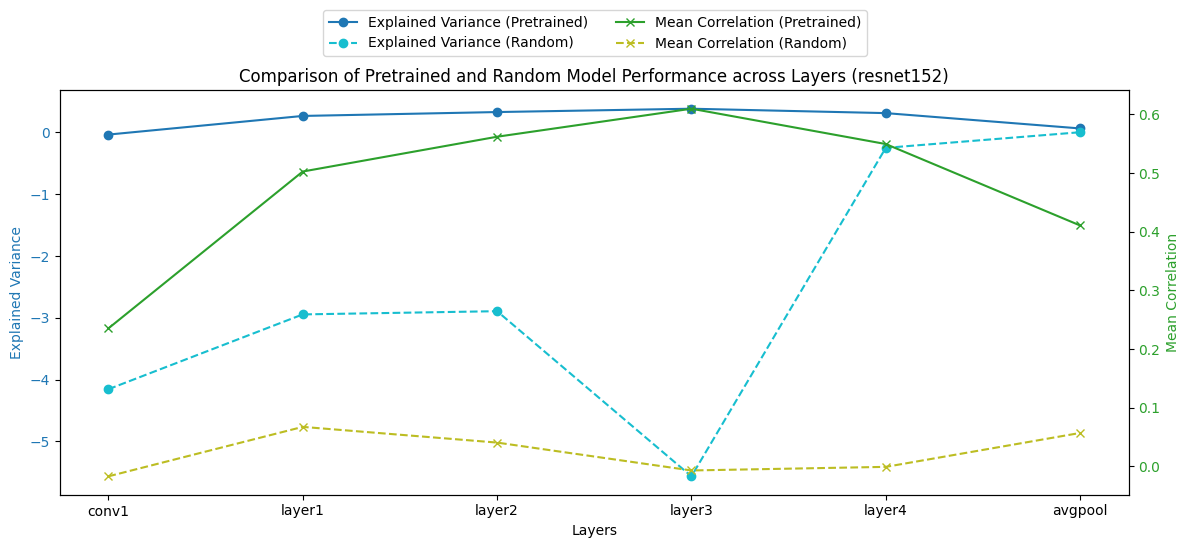

In [ ]:
layers_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

plot_ev_corr_comparison("resnet152", layers_labels, results_2, results_rand2)


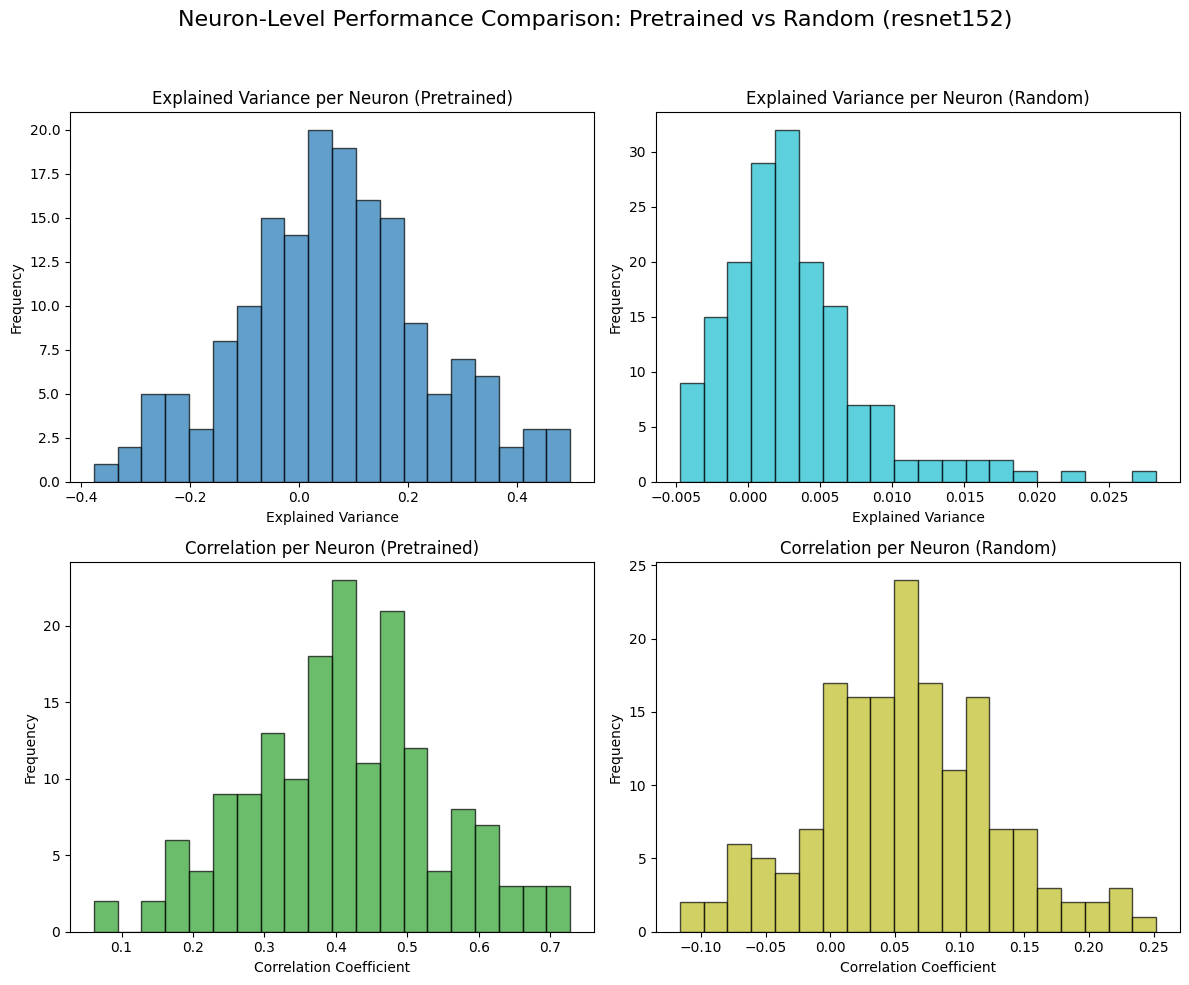

In [ ]:
plot_neuron_metrics_hist("resnet152", spikes_val, preds_val2, preds_val_rand2)

### PNASNet‑5 Large_

In [ ]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone3_pre = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone3_pre, "classifier"):          # many EfficientNet‑style models
    in_features = backbone3_pre.classifier.in_features
    backbone3_pre.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "fc"):                # ResNet‑style
    in_features = backbone3_pre.fc.in_features
    backbone3_pre.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone3_pre.head.in_features
    backbone3_pre.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "last_linear"):       # Inception / PNASNet
    in_features = backbone3_pre.last_linear.in_features
    backbone3_pre.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3_pre = backbone3_pre.cuda()

print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3_pre.parameters()):,}")


layers = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]


results_3 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_3 = extract_activations(model3_pre, train_loader, layer)
    val_act_3  = extract_activations(model3_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_3 .shape[1])
    pca_3  = PCA(n_components=n_components, random_state=42)
    X_train_pcs3  = pca_3 .fit_transform(train_act_3)
    X_val_pcs3  = pca_3 .transform(val_act_3)

    # Linear Regression
    lr3  = LinearRegression().fit(X_train_pcs3 , spikes_train )
    preds_val3  = lr3.predict(X_val_pcs3 )

    # Evaluation metrics
    ev_3  = explained_variance_score(spikes_val, preds_val3 )
    correlations_3  = [pearsonr(spikes_val[:, i], preds_val3[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_3  = np.mean(correlations_3 )

    results_3[layer] = {'explained_variance': ev_3, 'mean_correlation': avg_corr_3}

    print(f"{layer} | EV: {ev_3:.4f}, Mean Corr: {avg_corr_3:.4f}")

PNASNet‑5 Large parameters: 82,462,596
Processing cell_stem_0
cell_stem_0 | EV: 0.2221, Mean Corr: 0.4632
Processing cell_stem_1
cell_stem_1 | EV: 0.2801, Mean Corr: 0.5233
Processing cell_0
cell_0 | EV: 0.2933, Mean Corr: 0.5391
Processing cell_1
cell_1 | EV: 0.2747, Mean Corr: 0.5229
Processing cell_2
cell_2 | EV: 0.3441, Mean Corr: 0.5786
Processing cell_3
cell_3 | EV: 0.3437, Mean Corr: 0.5818
Processing cell_4
cell_4 | EV: 0.3834, Mean Corr: 0.6151
Processing cell_5
cell_5 | EV: 0.3820, Mean Corr: 0.6171
Processing cell_6
cell_6 | EV: 0.3812, Mean Corr: 0.6179
Processing cell_7
cell_7 | EV: 0.3533, Mean Corr: 0.5997
Processing cell_8
cell_8 | EV: 0.3525, Mean Corr: 0.6005
Processing cell_9
cell_9 | EV: 0.3275, Mean Corr: 0.5787
Processing cell_10
cell_10 | EV: 0.2917, Mean Corr: 0.5520


#### _Layer-wise Evaluation: PCA + Linear Regression on Randomly initialized PNASNet‑5 Large_

In [ ]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone NOT PRETRAINED on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone3_rand = timm.create_model("pnasnet5large", pretrained=False)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone3_rand, "classifier"):          # many EfficientNet‑style models
    in_features = backbone3_rand.classifier.in_features
    backbone3_rand.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "fc"):                # ResNet‑style
    in_features = backbone3_rand.fc.in_features
    backbone3_rand.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone3_rand.head.in_features
    backbone3_pre.rand = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "last_linear"):       # Inception / PNASNet
    in_features = backbone3_rand.last_linear.in_features
    backbone3_rand.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3_rand = backbone3_rand.cuda()

print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3_rand.parameters()):,}")

layers = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]

results_3_rand = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_3_rand = extract_activations(model3_rand, train_loader, layer)
    val_act_3_rand  = extract_activations(model3_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_3_rand .shape[1])
    pca_3_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs3_rand  = pca_3_rand .fit_transform(train_act_3_rand)
    X_val_pcs3_rand  = pca_3_rand .transform(val_act_3_rand)

    # Linear Regression
    lr3_rand  = LinearRegression().fit(X_train_pcs3_rand , spikes_train )
    preds_val3_rand  = lr3_rand.predict(X_val_pcs3_rand )

    # Evaluation metrics
    ev_3_rand = explained_variance_score(spikes_val, preds_val3_rand )
    correlations_3_rand  = [pearsonr(spikes_val[:, i], preds_val3_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_3_rand  = np.mean(correlations_3_rand )

    results_3_rand[layer] = {'explained_variance': ev_3_rand, 'mean_correlation': avg_corr_3_rand}

    print(f"{layer} | EV: {ev_3_rand:.4f}, Mean Corr: {avg_corr_3_rand:.4f}")

PNASNet‑5 Large parameters: 82,462,596
Processing cell_stem_0
cell_stem_0 | EV: 0.1762, Mean Corr: 0.4230
Processing cell_stem_1
cell_stem_1 | EV: 0.2082, Mean Corr: 0.4508
Processing cell_0
cell_0 | EV: 0.2410, Mean Corr: 0.4775
Processing cell_1
cell_1 | EV: 0.2482, Mean Corr: 0.4839
Processing cell_2
cell_2 | EV: 0.2441, Mean Corr: 0.4792
Processing cell_3
cell_3 | EV: 0.2408, Mean Corr: 0.4755
Processing cell_4
cell_4 | EV: 0.2291, Mean Corr: 0.4633
Processing cell_5
cell_5 | EV: 0.2150, Mean Corr: 0.4473
Processing cell_6
cell_6 | EV: 0.2019, Mean Corr: 0.4328
Processing cell_7
cell_7 | EV: 0.1908, Mean Corr: 0.4201
Processing cell_8
cell_8 | EV: 0.1723, Mean Corr: 0.3990
Processing cell_9
cell_9 | EV: 0.1453, Mean Corr: 0.3643
Processing cell_10
cell_10 | EV: 0.1293, Mean Corr: 0.3427


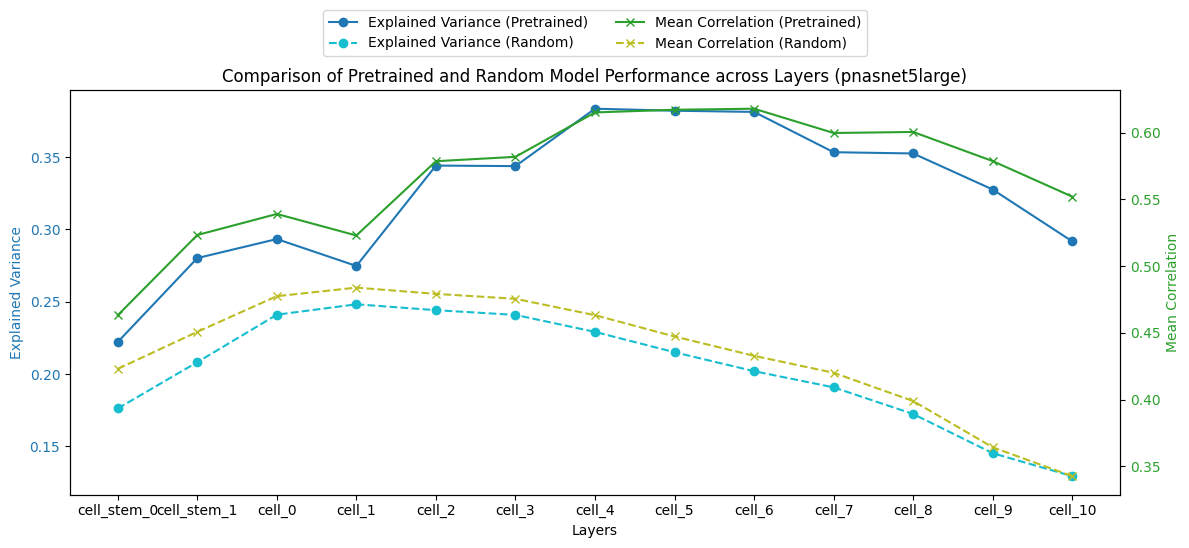

In [ ]:
layers_labels = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]

plot_ev_corr_comparison("pnasnet5large", layers_labels, results_3, results_3_rand)

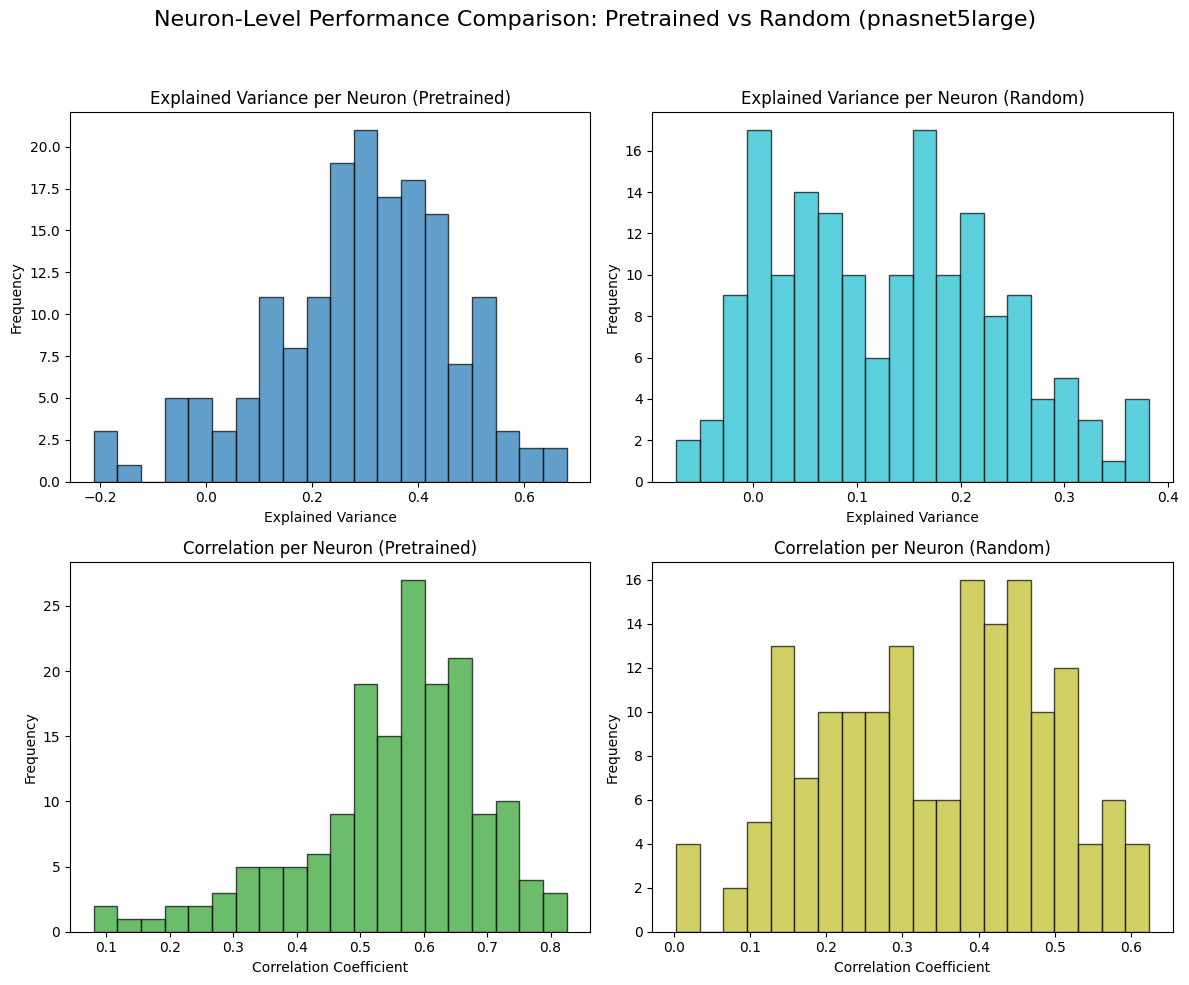

In [ ]:
plot_neuron_metrics_hist("pnasnet5large", spikes_val, preds_val3, preds_val3_rand)

---

## **Discussion of Results**

### 1. **Layer-Wise Performance**

* **DenseNet201** (Figure 1):

  * Pretrained model consistently outperforms the random baseline across all layers.
  * Both explained variance and mean correlation increase through the dense blocks and peak at `denseblock3/4`.
  * The pretrained variant offers \~0.4 EV and \~0.6 mean correlation at peak, vs. \~0.25/0.47 for the random model.
  * Suggests strong hierarchical feature buildup beneficial for spike prediction.

* **ResNet152** (Figure 3):

  * Pretrained model has low but positive explained variance across layers; random model shows negative EV — indicating **degenerate decoding**.
  * The pretrained model does better, but not by a large margin — \~0.05–0.1 EV advantage.
  * Performance is unstable, especially at deeper layers (`layer3`, `layer4`), where random initialization collapses entirely (EV ≈ -5).

* **PNASNet-5 Large** (Figure 5):

  * Pretrained and random models diverge most clearly in mid-to-late layers (`cell_3` to `cell_7`).
  * Peak performance from pretrained: \~0.38 EV, \~0.62 correlation.
  * Gradual degradation in late cells (`cell_9`, `cell_10`) may indicate overcompression or loss of spatial resolution.
  * Random model performs decently but with a consistent gap (0.1–0.15 lower).

---

### 2. **Neuron-Level Performance**

* **DenseNet201** (Figure 2):

  * Pretrained histograms show a healthy right skew, with many neurons achieving >0.3 EV and >0.6 correlation.
  * Random model still reasonable but flatter — shows lower spike predictivity across neurons.
  * Confirms that pretrained DenseNet representations align better with population activity.

* **ResNet152** (Figure 4):

  * Pretrained model yields a wide range of explained variances, many close to zero or negative — indicating **weak neuron-wise decoding**.
  * Random model performs very poorly; most EV values are close to zero and correlation centers around \~0.1–0.2.
  * Supports that ResNet152 is suboptimal for this decoding task, both at the population and single-neuron level.

* **PNASNet-5 Large** (Figure 6):

  * Pretrained model’s neurons show strong performance: peaks near 0.5 EV and 0.6–0.7 correlation.
  * Random model is clearly worse, though still competitive relative to ResNet’s pretrained version.
  * Overall spread is tighter and more consistent than ResNet, with fewer neurons at negative or near-zero EV.

---

##  **Summary Table**

| Model            | Init       | Layer-Wise Peak EV | Mean Corr (Peak) | Neuron-Level EV (Dist)         | Neuron-Level Corr (Dist) |
| ---------------- | ---------- | ------------------ | ---------------- | ------------------------------ | ------------------------ |
| **DenseNet201**  | Pretrained | **0.39**           | **0.62**         | Skewed toward 0.3–0.5          | Peak at 0.5–0.7          |
|                  | Random     | \~0.24             | \~0.47           | Lower spread, peak \~0.2–0.4   | Flatter, peaks \~0.4–0.5 |
| **ResNet152**    | Pretrained | \~0.1              | \~0.6            | Mixed, some near 0 or negative | Mostly 0.3–0.6           |
|                  | Random     | **< -4.0**         | **< 0.1**        | Clustered near 0               | Very weak \~0.1–0.2      |
| **PNASNet-5 Lg** | Pretrained | \~0.38             | \~0.62           | Concentrated near 0.4–0.6      | Peak at 0.5–0.7          |
|                  | Random     | \~0.25             | \~0.45           | Lower EV, wider spread         | Peak \~0.3–0.5           |

---

### Final Insight

* **DenseNet201** is the most effective and robust model for predicting neural activity.
* **PNASNet-5 Large** is a close second, with stronger layer-wise consistency but a slight drop in late-stage performance.
* **ResNet152** struggles, particularly when randomly initialized, suggesting that its architectural inductive biases are not well-suited for this spike prediction task.
